# I.Import et etudes fichiers

In [212]:
# installations et imports des autres packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import fonctions as fc

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,silhouette_samples
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [213]:
# file path
data_file_path = "DATA\data_standard.csv"
standard = pd.read_csv(data_file_path)
# file path
data_file_path = "DATA\data_robust.csv"
robust = pd.read_csv(data_file_path)
# file path
data_file_path = "DATA\data_minmax.csv"
minmax = pd.read_csv(data_file_path)

# Feature enginering

In [214]:
nb_clusters = 9

In [215]:
# selection du poids de la colonne
poids_prod = 2
poids_exp = 1
poids_imp = 1
poids_dispo_int = 1
poids_disp_prot = 3
poids_pib = 2
poids_politique = 3

In [216]:
# choix du datraframe
# data = robust
# data = standard
data = minmax

In [217]:
#Les colonnes à qui accorder le plus d'importance
data['Production / Population'] = np.exp(data['Production / Population']) * poids_prod
data['Exportations / Population'] = np.exp(data['Exportations / Population'])* poids_exp
data['Importations / Population'] = data['Importations / Population']* poids_imp
data['Disponibilité de protéines en quantité (kg/personne)'] = data['Disponibilité de protéines en quantité (kg/personne)'] * poids_disp_prot
data['PIB US $ par habitant'] = data['PIB US $ par habitant'] * poids_pib
data['Disponibilité intérieure/ Population'] = data['Disponibilité intérieure/ Population'] * poids_dispo_int
data['Political_Stability'] = data['Political_Stability'] * poids_politique

In [218]:
data_num = data.select_dtypes(include=[np.number])
pays = data['Zone']

# V.PCA

In [219]:
import pandas as pd
from sklearn.decomposition import PCA

def apply_pca(X):
    """
    Applique l'Analyse en Composantes Principales (ACP) sur les données X.

    Parameters:
        X (DataFrame): Les données d'entrée.

    Returns:
        pca (PCA): L'objet PCA ajusté.
    """
    # Créer les composantes principales
    pca = PCA()
    X_acp = pca.fit_transform(X)
    # Convertir en dataframe
    noms_composantes = [f"CP{i+1}" for i in range(X_acp.shape[1])]
    X_acp = pd.DataFrame(X_acp, columns=noms_composantes)
    # Créer les chargements
    chargements = pd.DataFrame(
        pca.components_.T,  # transposer la matrice des chargements
        columns=noms_composantes,  # les colonnes sont les composantes principales
        index=X.columns,  # les lignes sont les variables originales
    )
    return pca

def plot_variance(acp, largeur=8, dpi=100):
    """
    Trace les graphiques de la variance expliquée et cumulative de l'ACP.

    Parameters:
        acp (PCA): L'objet PCA ajusté.
        largeur (int): La largeur de la figure.
        dpi (int): La résolution de la figure.

    Returns:
        axs (array): Les axes des graphiques.
    """
    # Créer la figure
    fig, axs = plt.subplots(1, 2)
    n = acp.n_components_
    grille = np.arange(1, n + 1)
    # Variance expliquée
    variance_exp = acp.explained_variance_ratio_
    axs[0].bar(grille, variance_exp)
    axs[0].set(
        xlabel="Composante", title="% Variance Expliquée", ylim=(0.0, 1.0)
    )
    # Variance cumulative
    variance_cumul = np.cumsum(variance_exp)
    axs[1].plot(np.r_[0, grille], np.r_[0, variance_cumul], "o-")
    axs[1].set(
        xlabel="Composante", title="% Variance Cumulative", ylim=(0.0, 1.0)
    )
    # Configurer la figure
    fig.set(figwidth=largeur, dpi=dpi)
    return axs

In [220]:
pca = apply_pca(data_num)

array([<Axes: title={'center': '% Variance Expliquée'}, xlabel='Composante'>,
       <Axes: title={'center': '% Variance Cumulative'}, xlabel='Composante'>],
      dtype=object)

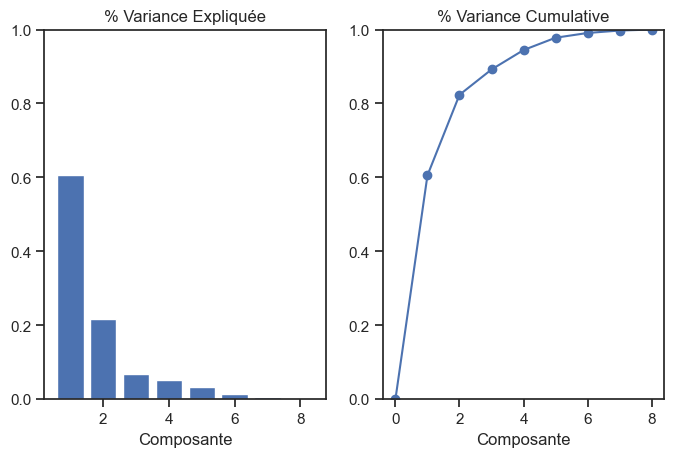

In [221]:
# Call the plot_variance function
plot_variance(pca)

Notre colonne F1 explique à elle seul 77% de l'information contneu dans nos données d'origine.

Nos deux colonnes F1 et F2 explique 87% de l'information contenu dans nos données d'origine.

Nos trois colonnes F1, F2 et F3 explique 96% de l'information contenu dans nos données d'origine.

## ACP 3 component

In [222]:
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(data_num)

PCA(n_components=3)

In [223]:
# Obtenir les composantes principales
pcs = pca.components_

# Convertir les composantes principales en un DataFrame
pcs = pd.DataFrame(pcs)

# Définir les noms des colonnes du DataFrame comme les noms des variables originales
features = data_num.columns
pcs.columns = features

# Définir les index du DataFrame comme les noms des composantes principales (F1, F2)
x_list = list(range(1, len(pcs) + 1))
pcs.index = [f"F{i}" for i in x_list]

# Arrondir les valeurs du DataFrame à deux décimales
pcs.round(2)

Disponibilité de protéines en quantité (kg/personne)  \
F1                                              -0.45      
F2                                               0.12      
F3                                               0.60      

    Disponibilité intérieure/ Population  Exportations / Population  \
F1                                 -0.09                      -0.09   
F2                                  0.17                       0.06   
F3                                  0.17                      -0.15   

    Importations / Population  Production / Population  Population  \
F1                      -0.05                    -0.72        0.00   
F2                       0.20                    -0.55       -0.10   
F3                       0.22                    -0.35       -0.01   

    PIB US $ par habitant  Political_Stability  
F1                  -0.39                -0.32  
F2                   0.20                 0.75  
F3                   0.36                -0.54

In [224]:
def plot_all_pca_correlation_circles(pca, features):
    n_components = pca.n_components_
    fig, axs = plt.subplots(n_components-1, n_components-1, figsize=(15, 15))

    for i in range(n_components):
        for j in range(i+1, n_components):
            ax = axs[i, j-1]  # j-1 car il n'y a pas de subplot pour i=j
            for k in range(0, pca.components_.shape[1]):
                ax.arrow(0, 0, pca.components_[i, k], pca.components_[j, k], head_width=0.07, head_length=0.07, width=0.02)
                ax.text(pca.components_[i, k] + 0.05, pca.components_[j, k] + 0.05, features[k])
            ax.plot([-1, 1], [0, 0], color='grey', ls='--')
            ax.plot([0, 0], [-1, 1], color='grey', ls='--')
            ax.set_xlabel('F{} ({}%)'.format(i+1, round(100*pca.explained_variance_ratio_[i],1)))
            ax.set_ylabel('F{} ({}%)'.format(j+1, round(100*pca.explained_variance_ratio_[j],1)))
            ax.set_title("Cercle des corrélations (F{} et F{})".format(i+1, j+1))
            an = np.linspace(0, 2 * np.pi, 100)
            ax.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale
            ax.axis('equal')

    plt.tight_layout()
    plt.show(block=False)

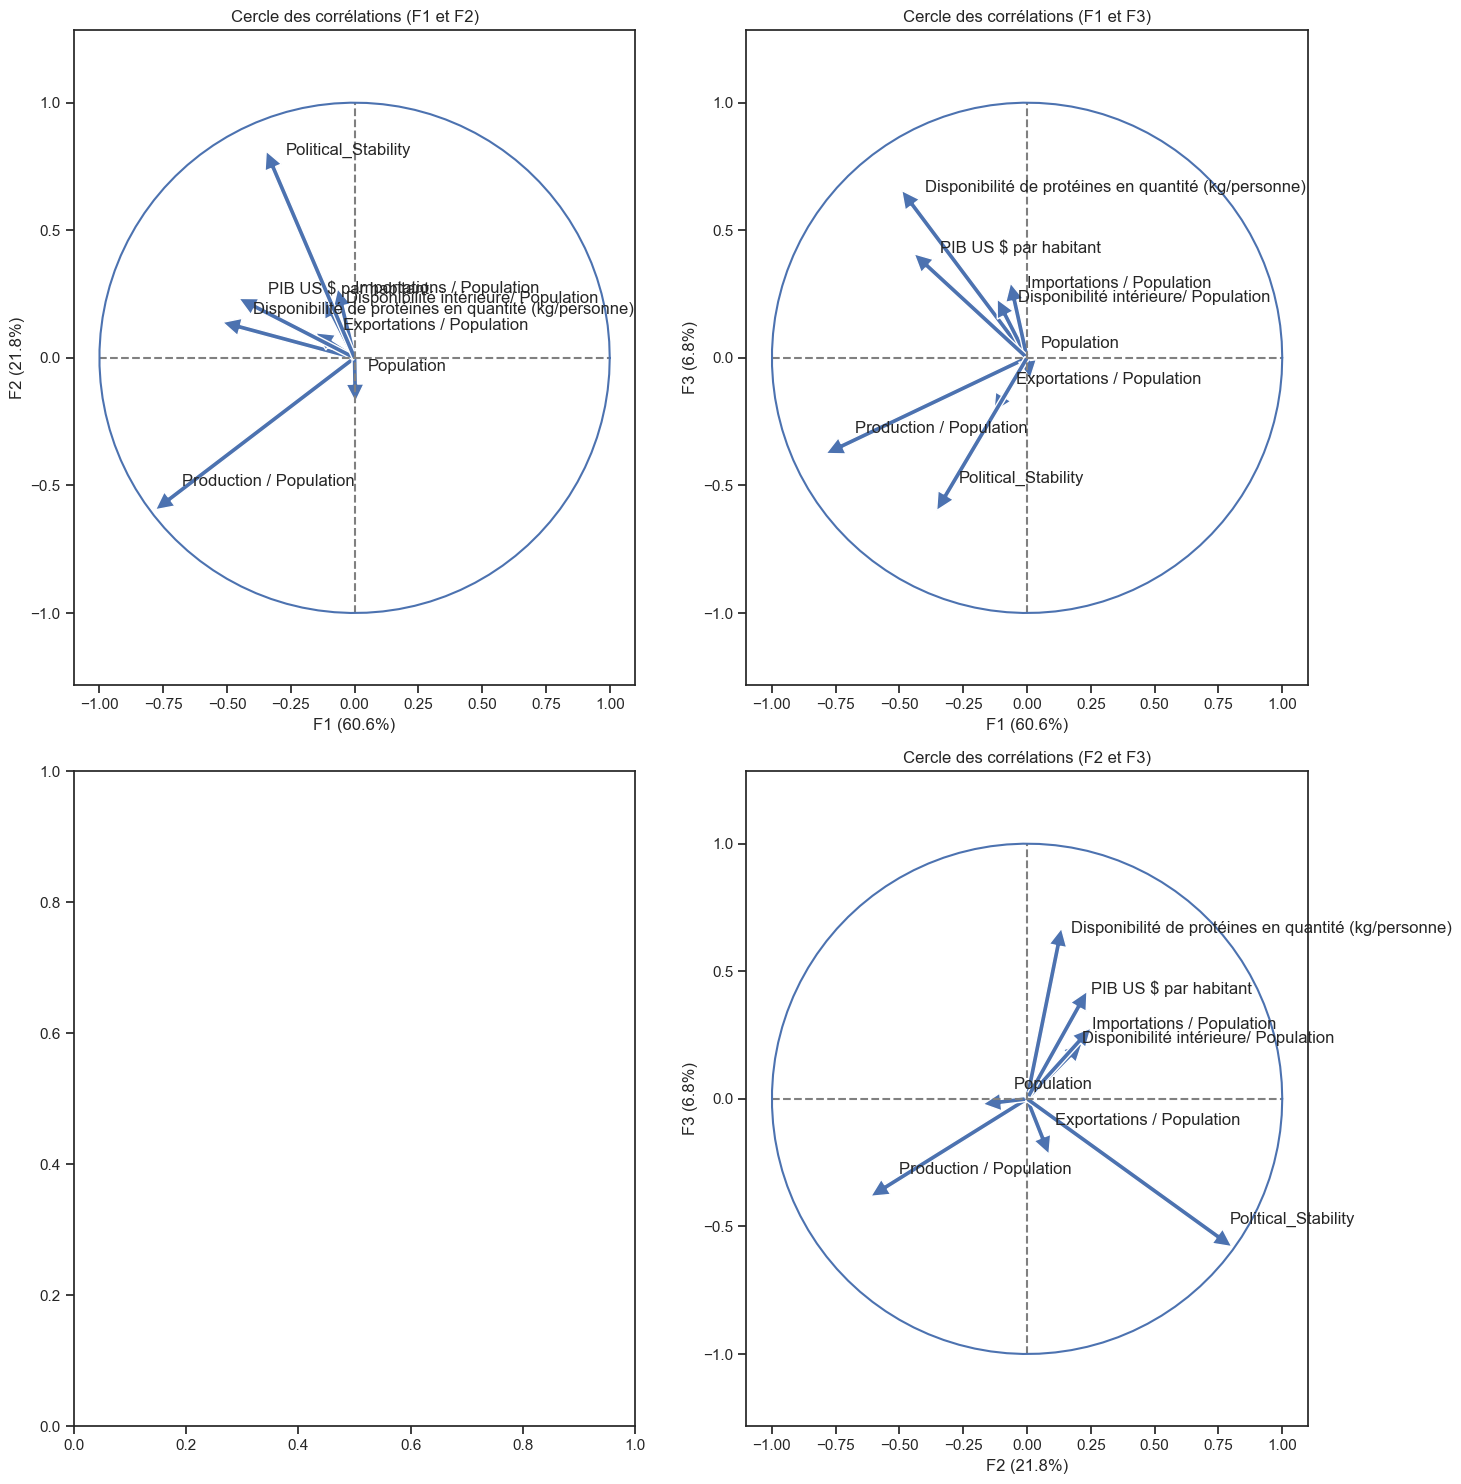

In [225]:
# Utilisation de la fonction
plot_all_pca_correlation_circles(pca, features)

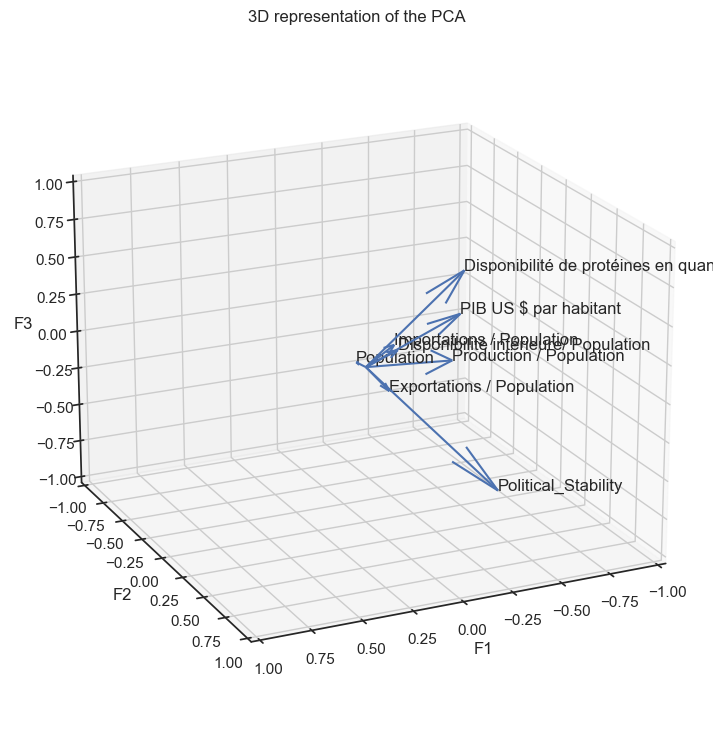

In [226]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection='3d')

for i in range(pca.components_.shape[1]):
    ax.quiver(0, 0, 0,
              pca.components_[0, i], pca.components_[1, i], pca.components_[2, i])

    ax.text(pca.components_[0, i], pca.components_[1, i], pca.components_[2, i], features[i])

ax.set_xlabel('F1')
ax.set_ylabel('F2')
ax.set_zlabel('F3')
ax.set_title("3D representation of the PCA")

# Définir les limites des axes
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])

ax.view_init(elev=20, azim=65)
plt.show()

In [227]:
import plotly.graph_objects as go

scaling_factor = 1.5  # Adjust the scaling factor as desired

fig = go.Figure()

for i in range(pca.components_.shape[1]):
    # Add a line for the vector
    fig.add_trace(go.Scatter3d(
        x=[0, pca.components_[0, i] * scaling_factor],
        y=[0, pca.components_[1, i] * scaling_factor],
        z=[0, pca.components_[2, i] * scaling_factor],
        mode='lines',
        name=features[i]
    ))

    # Add a cone for the arrowhead
    fig.add_trace(go.Cone(
        x=[pca.components_[0, i] * scaling_factor],
        y=[pca.components_[1, i] * scaling_factor],
        z=[pca.components_[2, i] * scaling_factor],
        u=[pca.components_[0, i] * scaling_factor],
        v=[pca.components_[1, i] * scaling_factor],
        w=[pca.components_[2, i] * scaling_factor],
        sizemode="absolute",
        sizeref=0.2,
        anchor="cm"
    ))

fig.update_layout(
    title="3D representation of the PCA",
    scene=dict(
        xaxis_title='F1',
        yaxis_title='F2',
        zaxis_title='F3',
        aspectratio=dict(x=1, y=1, z=1),
        camera=dict(eye=dict(x=1.2, y=1.2, z=0.6))
    ),
    legend=dict(
        yanchor="top",
        y=0.1,
        xanchor="left",
        x=0.001
    )
)

fig.show()

In [228]:
import plotly.graph_objects as go

principal_components_pivot = pca.fit_transform(data_num)

fig = go.Figure(data=[go.Scatter3d(
    x=principal_components_pivot[:, 0],
    y=principal_components_pivot[:, 1],
    z=principal_components_pivot[:, 2],
    mode='markers',
    marker=dict(
        size=5,
        opacity=0.8
    )
)])

fig.update_layout(
    title='ACP - Vue en 3D',
    scene = dict(
        xaxis_title='Composante principale 1',
        yaxis_title='Composante principale 2',
        zaxis_title='Composante principale 3'
    )
)

fig.show()

In [229]:
X_proj = pca.transform(data_num)
df = pd.DataFrame(X_proj, columns = ["F1", "F2","F3"])
df_test = df.copy()
df.head()

F1        F2        F3
0  2.266964 -1.071002  0.457815
1 -0.879198 -0.321601  0.030163
2  0.109542  0.507469  0.065912
3  0.537434 -0.521401 -0.032069
4 -0.821921 -0.024524  0.155151

# PIPE  

## Dendogramme

In [230]:
# # Créer le pipeline pour le dendogramme
# pipe_dendogramme = Pipeline([
#     ('scaler', StandardScaler()),
#     ('agg', AgglomerativeClustering(n_clusters=nb_clusters, linkage='ward'))
# ])


# def create_dendrogram(df, pipe_dendogramme):
#     """Crée et affiche un dendrogramme pour un DataFrame donné, en utilisant un pipeline donné."""
#     Z = linkage(pipe_dendogramme['scaler'].transform(df), method='ward')
#     clusters = fcluster(Z, 3, criterion='maxclust')
#     plt.figure(figsize=(10, 7))
#     dendrogram(Z)
#     plt.show()

In [231]:
# # Ajuster le pipeline
# pipe_dendogramme.fit(df)
# create_dendrogram(df, pipe_dendogramme)

## Kmeans

In [232]:
# # créer le pipeline pour le kmeans
# pipe_kmeans = Pipeline([
#     ('scaler', StandardScaler()),
#     ('kmeans', KMeans(n_clusters=nb_clusters, random_state=0))
# ])

In [233]:
# # ajuster le pipeline]
# pipe_kmeans.fit(df)

# IV. CAH -- Dendogramme

Nous allons effectuer une classification ascendante hiérarchique avec la méthode de ward. Cette méthode est utilisé pour calculer les distances entre cluster et minimiser la variance intra cluster.

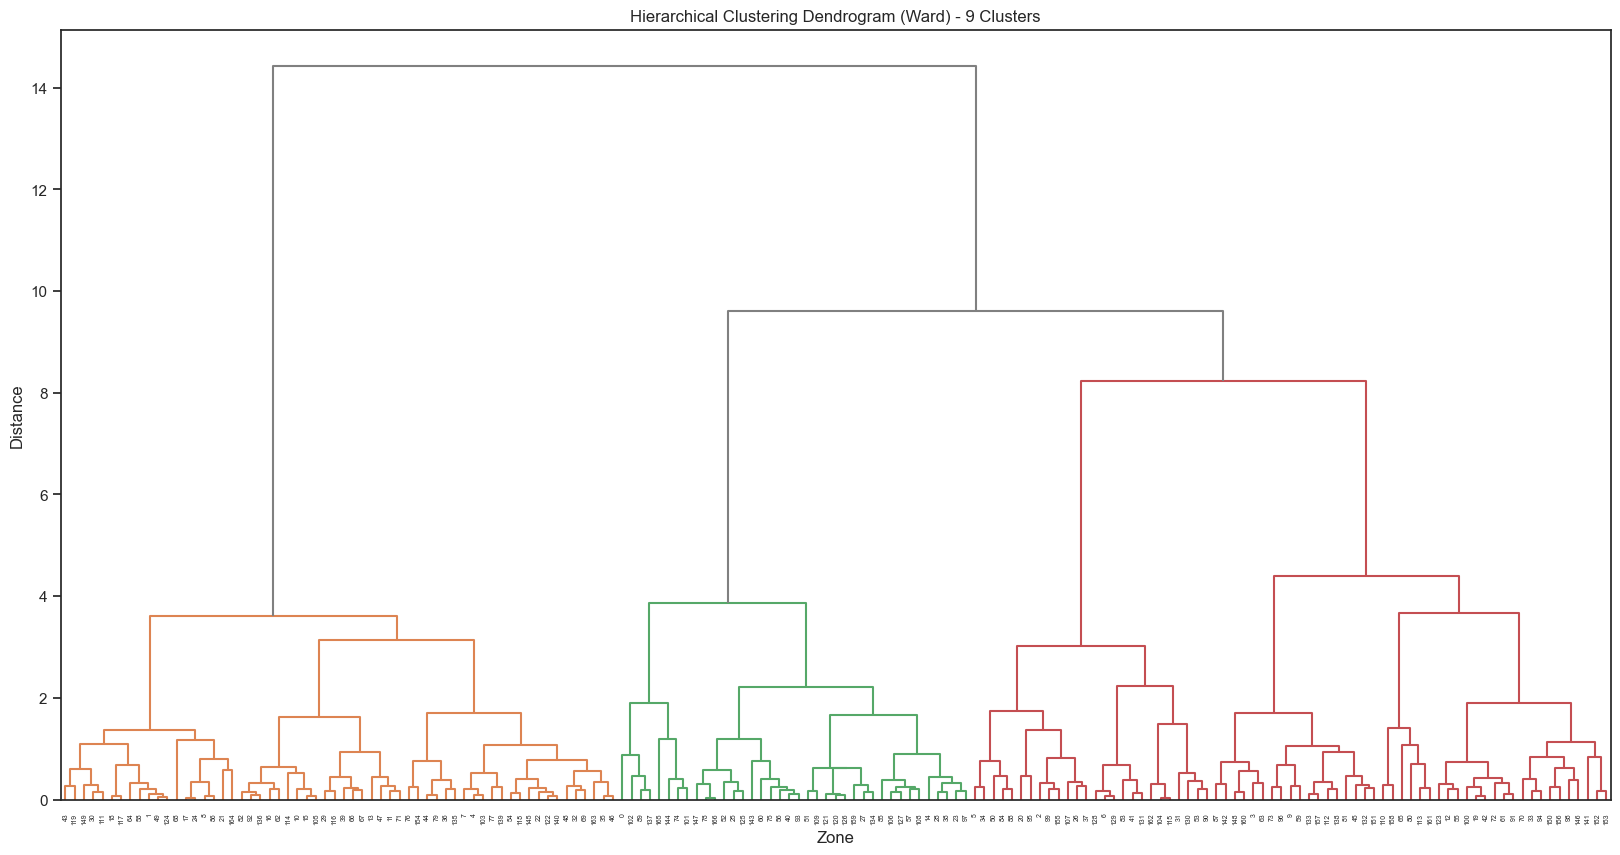

In [234]:
from scipy.cluster.hierarchy import fcluster

# Création du dendrogramme
Z = linkage(df, 'ward')

# Nombre de clusters souhaité
k = nb_clusters

# Coupage du dendrogramme en clusters
clusters = fcluster(Z, nb_clusters, criterion='maxclust')

# Affichage du dendrogramme avec les couleurs de clusters
plt.figure(figsize=(20, 10))
plt.title(f'Hierarchical Clustering Dendrogram (Ward) - {k} Clusters')
plt.xlabel('Zone')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90, color_threshold=k, above_threshold_color='grey')
plt.show()

# VI.Kmeans

Nous allons utiliser la méthode du coude et le score de silhouette afin de trouver le nombre de clusters que nous allons définir pour notre Kmeans.

In [236]:
# Import the os module
import os
# Set the environment variable 'OMP_NUM_THREADS' to '1'
os.environ['OMP_NUM_THREADS'] = '1'

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than 

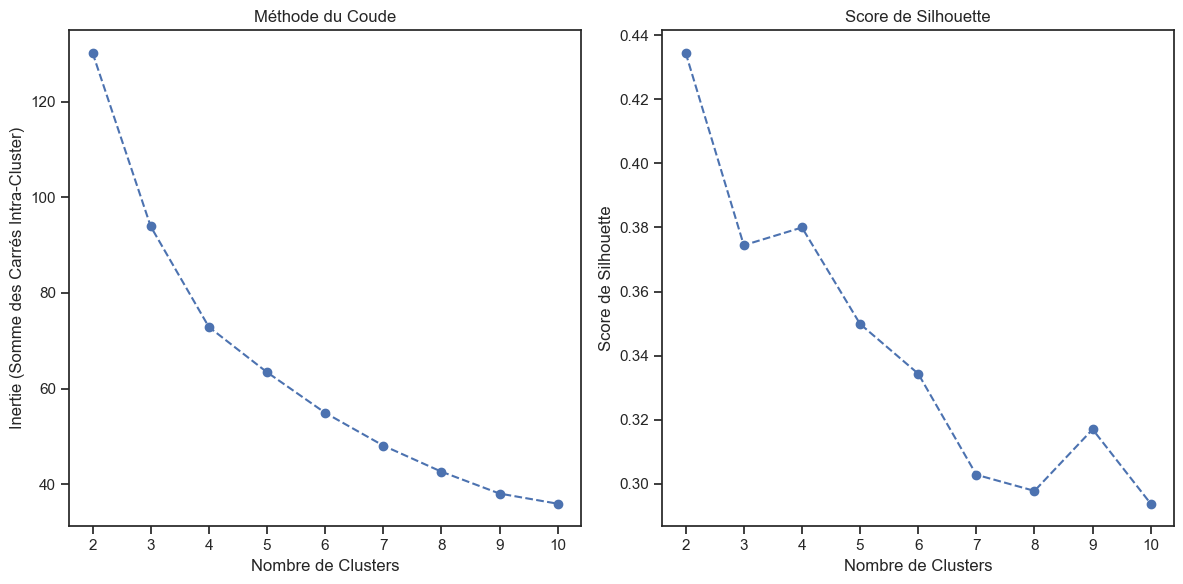

In [237]:
# Définir une plage de nombres de clusters à tester
plage_de_clusters = range(2, 11) 

# Listes pour stocker l'inertie et les scores de silhouette
valeurs_inertie = []
scores_silhouette = []

# Itérer à travers différents nombres de clusters et ajuster K-Means
for n_clusters in plage_de_clusters:
    kmeans_pivot = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    clusters_pivot = kmeans_pivot.fit_predict(df_test)

    # Calculer l'inertie (somme des carrés intra-cluster)
    valeurs_inertie.append(kmeans_pivot.inertia_)

    # Calculer le score de silhouette
    scores_silhouette.append(silhouette_score(df_test, clusters_pivot))

# Tracer la méthode du coude pour déterminer le nombre optimal de clusters
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(plage_de_clusters, valeurs_inertie, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Inertie (Somme des Carrés Intra-Cluster)')
plt.title('Méthode du Coude')

# Tracer le Score de Silhouette pour déterminer le nombre optimal de clusters
plt.subplot(1, 2, 2)
plt.plot(plage_de_clusters, scores_silhouette, marker='o', linestyle='--')
plt.xlabel('Nombre de Clusters')
plt.ylabel('Score de Silhouette')
plt.title('Score de Silhouette')

plt.tight_layout()
plt.show()

Méthode du Coude (Elbow Method) :

La Méthode du Coude consiste à trouver le point dans un graphique de l'inertie où la diminution de l'inertie ralentit, formant un coude.
Ce point représente généralement le nombre optimal de clusters dans une analyse de clustering.

Score de Silhouette (Silhouette Score) :

Le Score de Silhouette mesure à quel point les points d'un cluster sont similaires entre eux et différents des autres clusters.
Il varie de -1 à 1, où un score élevé indique une meilleure séparation des clusters.
Le nombre optimal de clusters est généralement celui qui donne le score de silhouette le plus élevé.

Nous allons garder 9 clusters, le nombre optimal de clusters au vu des résultats serait 3. Cependant pour l'analyse métier avoir des cluster plsu petit et précis vont eprmettre d'affiner notre analyse. 

In [238]:
# Importer la classe KMeans du module sklearn.cluster
from sklearn.cluster import KMeans

# Créer une instance de la classe KMeans avec 2 clusters
kmeans = KMeans(n_clusters=nb_clusters, n_init=10, random_state=42)

# Entraîner le modèle KMeans sur les données numériques
kmeans.fit(df_test)

c:\Users\antoi\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



KMeans(n_clusters=9, n_init=10, random_state=42)

On va cherche les labels de nôre Kmeans afin d'attribuer plus tard un cluster à chaque pays

In [239]:
# Obtenir les labels attribués par KMeans à chaque échantillon
labels = kmeans.labels_
labels[:10]

array([7, 8, 3, 6, 2, 1, 3, 2, 8, 6])

In [240]:
# Ajouter la colonne 'cluster_kmeans' au dataframe 'data' avec les labels attribués par KMeans
df['cluster_kmeans'] = kmeans.labels_

In [241]:
import plotly.express as px

fig = px.scatter_3d(df, x='F1', y='F2', z='F3', color='cluster_kmeans', color_continuous_scale='Viridis')

fig.update_layout(title='Graphique des clusters en 3D')
fig.show()

Ajoutons les centroids de nos clusters

In [242]:
centroids = kmeans.cluster_centers_
centroids

array([[-0.33155201, -0.74335297,  0.17017133],
       [ 1.22303558,  0.18880945, -0.16359548],
       [-0.70984673,  0.24828593, -0.03227991],
       [ 0.10124971,  0.98630623,  0.36372297],
       [ 0.81209383, -1.18244336,  0.68387848],
       [-1.41239203,  0.14932226, -0.27510308],
       [ 0.39960453, -0.09544955, -0.09323474],
       [ 2.02505398, -0.56867909, -0.08038166],
       [-1.14201987, -0.52070504, -0.05964024]])

In [243]:
import plotly.graph_objects as go

fig = px.scatter_3d(df, x='F1', y='F2', z='F3', color='cluster_kmeans', color_continuous_scale='Viridis')

# Ajouter les centroïdes au graphique
fig.add_trace(go.Scatter3d(x=centroids[:, 0], y=centroids[:, 1], z=centroids[:, 2], 
                           mode='markers',
                           marker=dict(size=10, color='red'), 
                           name='centroids'))

fig.update_layout(title='Graphique des clusters en 3D')
fig.show()

# Reconstruction de notre df apres le clustering

Nous allons reconstruire notre dataframe initial en répétant les mêmes étapes dans l'autre sens. Le but est de pouvori avoir une image plus facile pour nos futurs comparaisons. Nosu allons aussi comparer nos deuc clusterings.

In [244]:
# ajout de la colonne 'cluster_dd' au dataframe 'data' avec les labels attribués par le dendogramme
df['cluster_dd'] = clusters
# Ajouter la colonne 'cluster_kmeans' au dataframe 'data' avec les labels attribués par KMeans
df['cluster_kmeans'] = kmeans.labels_

In [245]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Créer une figure avec 2 subplots
fig = make_subplots(rows=1, cols=2, subplot_titles=('K-Means Clustering', 'Clustering CAH'), specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# Ajouter le scatter plot pour le clustering K-Means au premier subplot
fig.add_trace(
    go.Scatter3d(x=df['F1'], y=df['F2'], z=df['F3'], mode='markers', marker=dict(color=df['cluster_kmeans'], size=5, colorscale='Viridis', opacity=0.8)),
    row=1, col=1
)

# Ajouter le scatter plot pour le clustering basé sur le dendrogramme au deuxième subplot
fig.add_trace(
    go.Scatter3d(x=df['F1'], y=df['F2'], z=df['F3'], mode='markers', marker=dict(color=df['cluster_dd'], size=5, colorscale='Viridis', opacity=0.8)),
    row=1, col=2
)

# Mettre à jour les layouts pour ajouter les labels d'axes
fig.update_layout(height=600, width=800)
fig.update_xaxes(title_text="Feature1", row=1, col=1)
fig.update_yaxes(title_text="Feature2", row=1, col=1)
fig.update_xaxes(title_text="Feature1", row=1, col=2)
fig.update_yaxes(title_text="Feature2", row=1, col=2)

fig.show()

Reconstruction de nos données d'origine en y ajoutant nos clusters

In [246]:
# Reconstruire les données d'origine
data_reconstructed = pca.inverse_transform(df_test)

# Conversion de l'array en DataFrame
data_reconstructed = pd.DataFrame(data_reconstructed)
column_names = data_num.columns
data_reconstructed.columns = column_names

data_reconstructed.head()

Disponibilité de protéines en quantité (kg/personne)  \
0                                           1.284617      
1                                           2.532535      
2                                           2.209980      
3                                           1.834476      
4                                           2.617696      

   Disponibilité intérieure/ Population  Exportations / Population  \
0                              0.238029                   1.402897   
1                              0.560061                   1.807047   
2                              0.619541                   1.759058   
3                              0.395235                   1.672060   
4                              0.625586                   1.800572   

   Importations / Population  Production / Population  Population  \
0                   0.433553                 2.642882    0.192866   
1                   0.645997                 4.655960    0.115013   
2                   0.773268                 3.468689    0.030942   
3                   0.520978                 3.761325    0.139017   
4                   0.731605                 4.407064    0.082953   

   PIB US $ par habitant  Political_Stability  
0               0.005625             0.173446  
1               1.232189             1.965190  
2               1.025053             2.249046  
3               0.615827             1.398195  
4               1.314465             2.101184

In [247]:
#On refait les étapes dans l'autre sens pour obtenir les données d'origine
data['Production / Population'] = np.log(data['Production / Population']) / poids_prod
data['Exportations / Population'] = np.log(data['Exportations / Population'])/ poids_exp
data['Importations / Population'] = data['Importations / Population']/poids_imp
data['Disponibilité de protéines en quantité (kg/personne)'] = data['Disponibilité de protéines en quantité (kg/personne)'] / poids_disp_prot
data['PIB US $ par habitant'] = data['PIB US $ par habitant'] / poids_pib
data['Disponibilité intérieure/ Population'] = data['Disponibilité intérieure/ Population'] / poids_dispo_int

In [248]:
# Supprimer la colonne 'cluster_kmeans' du dataframe 'data_reconstructed' car après le feature enginering, elle n'a plus assez de sens
data_reconstructed.drop(['Production / Population'], axis=1, inplace=True)

In [249]:
# on va rapprocher nos clusters avec le dataframe initial
data_reconstructed['cluster_kmeans'] = df['cluster_kmeans']  
data_reconstructed['cluster_dd'] = df['cluster_dd']
data_reconstructed['Pays'] = pays
# Déplace les colonnes en premier 
data_reconstructed = data_reconstructed.set_index(['Pays', 'cluster_kmeans', 'cluster_dd']).reset_index()
data_reconstructed.head()

Pays  cluster_kmeans  cluster_dd  \
0     Afghanistan               7           4   
1  Afrique du Sud               8           1   
2         Albanie               3           6   
3         Algérie               6           7   
4       Allemagne               2           3   

   Disponibilité de protéines en quantité (kg/personne)  \
0                                           1.284617      
1                                           2.532535      
2                                           2.209980      
3                                           1.834476      
4                                           2.617696      

   Disponibilité intérieure/ Population  Exportations / Population  \
0                              0.238029                   1.402897   
1                              0.560061                   1.807047   
2                              0.619541                   1.759058   
3                              0.395235                   1.672060   
4                              0.625586                   1.800572   

   Importations / Population  Population  PIB US $ par habitant  \
0                   0.433553    0.192866               0.005625   
1                   0.645997    0.115013               1.232189   
2                   0.773268    0.030942               1.025053   
3                   0.520978    0.139017               0.615827   
4                   0.731605    0.082953               1.314465   

   Political_Stability  
0             0.173446  
1             1.965190  
2             2.249046  
3             1.398195  
4             2.101184

In [250]:
data_reconstructed.describe()

cluster_kmeans  cluster_dd  \
count      167.000000  167.000000   
mean         3.419162    4.832335   
std          2.605206    2.475550   
min          0.000000    1.000000   
25%          1.000000    3.000000   
50%          3.000000    5.000000   
75%          6.000000    7.000000   
max          8.000000    9.000000   

       Disponibilité de protéines en quantité (kg/personne)  \
count                                         167.000000      
mean                                            2.158282      
std                                             0.513387      
min                                             0.411568      
25%                                             1.770067      
50%                                             2.291203      
75%                                             2.546397      
max                                             3.084086      

       Disponibilité intérieure/ Population  Exportations / Population  \
count                            167.000000                 167.000000   
mean                               0.533368                   1.748788   
std                                0.147523                   0.115983   
min                                0.110322                   1.402897   
25%                                0.441550                   1.675474   
50%                                0.534319                   1.752557   
75%                                0.619443                   1.835281   
max                                0.889520                   1.961691   

       Importations / Population  Population  PIB US $ par habitant  \
count                 167.000000  167.000000             167.000000   
mean                    0.660816    0.083867               0.942214   
std                     0.156522    0.063949               0.439952   
min                     0.298551   -0.093967              -0.527392   
25%                     0.548708    0.044085               0.612209   
50%                     0.651876    0.081947               1.025053   
75%                     0.737273    0.128173               1.314997   
max                     1.113737    0.236279               1.601197   

       Political_Stability  
count           167.000000  
mean              1.941024  
std               0.596366  
min               0.036595  
25%               1.596671  
50%               1.988987  
75%               2.423646  
max               3.003273

In [251]:
# Calculer les différences absolues entre le dataframe original et le dataframe reconstruit
differences = abs(data_num - data_reconstructed.drop(['cluster_kmeans', 'cluster_dd', 'Pays'], axis=1))

# Afficher les différences
print(differences.mean().sort_values(ascending=False))

Exportations / Population                               0.187115
PIB US $ par habitant                                   0.184269
Disponibilité de protéines en quantité (kg/personne)    0.111789
Importations / Population                               0.095112
Disponibilité intérieure/ Population                    0.082551
Population                                              0.079692
Political_Stability                                     0.044857
Production / Population                                      NaN
dtype: float64


In [252]:
# on va calculer le variance expliquée par les 3 composantes principales
explained_variance = pca.explained_variance_ratio_.sum()
explained_variance

0.8919750296610922

On avait que 92% de notre jeu de données expliqué par nos 3 composantes principal mais on retrouve quand même un jeu de données proche

In [253]:
data_reconstructed_num = data_reconstructed.select_dtypes(include=[np.number])

In [254]:
# Modification du type des colonnes 'cluster_kmeans' et 'cluster_dd' en 'str'
data_reconstructed['cluster_kmeans'] = data_reconstructed['cluster_kmeans'].astype(str)
data_reconstructed['cluster_dd'] = data_reconstructed['cluster_dd'].astype(str)
data_recontructed_num = data_reconstructed.select_dtypes(include=[np.number])

# Evaluation des clusters


On va évaluer la qualité de notre clustering, nous allons utiliser le score de silhouette moyen 

## Score de silhouette

### Kmeans

Score de silhouette moyen : 0.31700464694928726


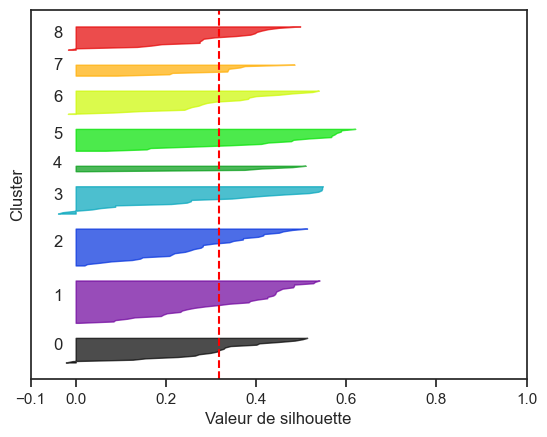

In [255]:
# Calculer le score de silhouette moyen
silhouette_avg = silhouette_score(df_test, labels)
print(f"Score de silhouette moyen : {silhouette_avg}")

# Calculer les scores de silhouette individuels pour chaque échantillon
sample_silhouette_values = silhouette_samples(df_test, labels)

# Créer un silhouette plot
fig, ax = plt.subplots()
y_lower = 10

for i in range(len(np.unique(labels))):
    # Aggrège les scores de silhouette pour les échantillons appartenant à un cluster particulier
    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / len(np.unique(labels)))
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Étiqueter chaque cluster avec son numéro au milieu
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calculer la nouvelle position y_lower pour le prochain plot
    y_lower = y_upper + 10

ax.set_xlabel("Valeur de silhouette")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()


### Dendogramme

Score de silhouette moyen : 0.2993195163227867


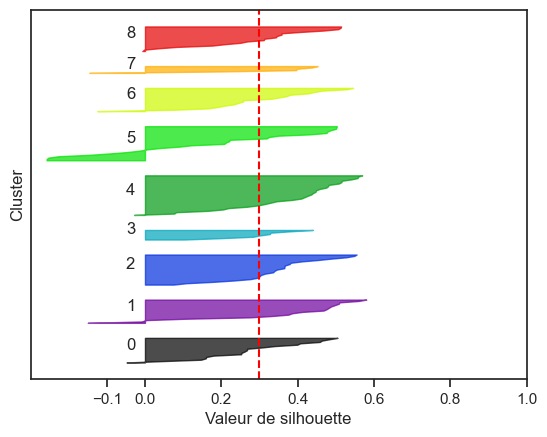

In [256]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score

# Réorganiser les numéros de cluster pour qu'ils soient continus de 0 à 1
clusters = clusters - 1

# Calculer le score de silhouette moyen
silhouette_avg = silhouette_score(df_test, clusters)
print(f"Score de silhouette moyen : {silhouette_avg}")

# Calculer les scores de silhouette individuels pour chaque échantillon
sample_silhouette_values = silhouette_samples(df_test, clusters)

# Créer un silhouette plot
fig, ax = plt.subplots()
y_lower = 10

for i in range(len(np.unique(clusters))):
    # Aggrège les scores de silhouette pour les échantillons appartenant à un cluster particulier
    ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / len(np.unique(clusters)))
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Étiqueter chaque cluster avec son numéro au milieu
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calculer la nouvelle position y_lower pour le prochain plot
    y_lower = y_upper + 10

ax.set_xlabel("Valeur de silhouette")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
ax.set_yticks([])
ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

Après le feature enginering nosu obtenons des scores de siloheutte plus faible. Après plusieurs itérations différentes j'ai réussi à monter jusqu'à 0.60 mais je n'avais pas assez de matière afin de fournir un analyse métier intéressante.

Nous allons garder notre clustering Kmeans car le score est légèrement plus élevé.

## ARI

In [257]:
# Importer la fonction adjusted_rand_score du module sklearn.metrics
from sklearn.metrics import adjusted_rand_score

# Obtenir les labels attribués par KMeans et le dendrogramme
labels_kmeans = kmeans.labels_
labels_dendrogramme = clusters

# Calculer l'Indice de Rand Ajusté (ARI) en comparant les deux ensembles de labels
ari = adjusted_rand_score(labels_kmeans, labels_dendrogramme)

# Afficher le résultat
print("Indice de Rand :", ari)

Indice de Rand : 0.8114925974198591


Nos deux clustering sont relativement proche au vu du résulat de notre ari plus proche de 1 que de 0.

# Etude des clusters

### Fonctions pour l'étude des clusters

In [258]:
from math import pi

def get_cluster_data(data, cluster_column, cluster_value):
    """Renvoie un sous-ensemble de données pour le cluster spécifié."""
    return data[data[cluster_column] == cluster_value]

def radar_plot(*cluster_data_list):
    """Crée un radar plot pour les variables numériques de plusieurs clusters."""
    for i, cluster_data in enumerate(cluster_data_list):
        numeric_columns = cluster_data.select_dtypes(include='number').columns
        stats = cluster_data[numeric_columns].mean().tolist()
        stats += stats[:1]  # repeat the first value to close the circular graph
        angles = [n / float(len(numeric_columns)) * 2 * pi for n in range(len(numeric_columns))]
        angles += angles[:1]
        plt.polar(angles, stats, label=f'Cluster {i+1}')  # Ajoutez un label à chaque plot
        plt.fill(angles, stats, alpha=0.1)
    plt.xticks(angles[:-1], numeric_columns)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Ajoutez une légende à droite du graphique
    plt.show() 

def plot_boxplot(data):
    """Crée un boxplot pour toutes les colonnes numériques côte à côte."""
    numeric_columns = data.select_dtypes(include='number').columns
    sns.boxplot(data=data[numeric_columns])
    plt.xticks(rotation=90)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité
    plt.show()
    
def radar_plot_subplot(cluster_data_list, ax):
    """Crée un radar plot pour les variables numériques de plusieurs clusters."""
    max_val = None
    for cluster_data in cluster_data_list:
        numeric_columns = cluster_data.select_dtypes(include='number').columns
        stats = cluster_data[numeric_columns].mean().tolist()
        if max_val is None or max(stats) > max_val:
            max_val = max(stats)  # Mettre à jour la valeur maximale
        stats += stats[:1]  # repeat the first value to close the circular graph
        angles = [n / float(len(numeric_columns)) * 2 * pi for n in range(len(numeric_columns))]
        angles += angles[:1]
        ax.plot(angles, stats)  # Utilisez plot au lieu de polar
        ax.fill(angles, stats, alpha=0.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(numeric_columns)
    ax.set_ylim(0, max_val)  # Définir les limites de l'axe y

def plot_boxplot_subplot(data, ax):
    """Crée un boxplot pour toutes les colonnes numériques côte à côte."""
    numeric_columns = data.select_dtypes(include='number').columns
    sns.boxplot(data=data[numeric_columns], ax=ax)
    ax.set_xticklabels(numeric_columns, rotation=90)  # Rotation des étiquettes sur l'axe des x pour une meilleure lisibilité

def plot_subplots(cluster_data_list, data):
    """Crée un subplot avec un radar plot et un boxplot."""
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.add_subplot(121, polar=True)
    ax2 = fig.add_subplot(122)
    radar_plot_subplot(cluster_data_list, ax1)
    plot_boxplot_subplot(data, ax2)
    plt.show()
    
def descriptive_statistics(cluster_data):
    """Affiche les statistiques descriptives pour les colonnes numériques du cluster."""
    numeric_columns = cluster_data.select_dtypes(include='number')
    print(numeric_columns.describe())
    
def analyze_cluster(data, cluster_column, cluster_value):
    """Analyse un cluster spécifié en appelant toutes les fonctions."""
    cluster_data = get_cluster_data(data, cluster_column, cluster_value)
    print('Boxplot et radarplot pour le cluster', cluster_value)
    plot_subplots([cluster_data], data)
    # print("Boxplot des colonnes numériques :")
    # plot_boxplot(cluster_data)
    # print("Radar plot des colonnes numériques :")
    # radar_plot(cluster_data)
    # print("Statistiques descriptives des colonnes numériques :")
    # descriptive_statistics(cluster_data)    

Création des datframes à partir des clusters

In [259]:
from scipy import cluster
# Créez des DataFrames pour chaque cluster Kmeans
cluster_kmeans_dfs = []
for i in range(nb_clusters):
    cluster_kmeans_df = get_cluster_data(data_reconstructed, 'cluster_kmeans', str(i))
    cluster_kmeans_dfs.append(cluster_kmeans_df)

# Créez des DataFrames pour chaque cluster dendogramme
cluster_dd_dfs = []
for i in range(nb_clusters):
    cluster_dd_df = get_cluster_data(data_reconstructed, 'cluster_dd', str(i))
    cluster_dd_dfs.append(cluster_dd_df)

### Etude global des clusters

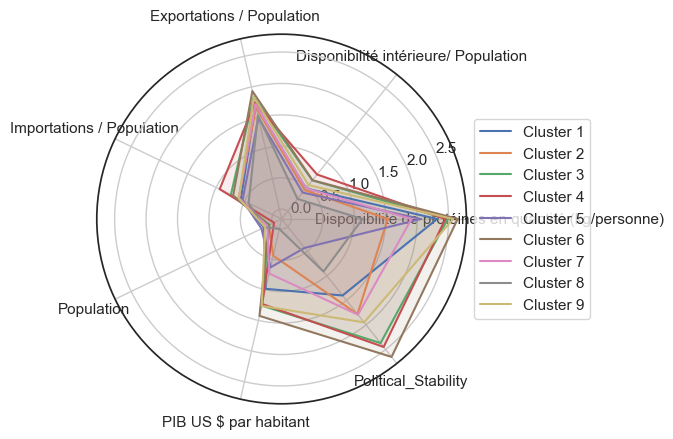

In [260]:
radar_plot(cluster_kmeans_dfs[0], cluster_kmeans_dfs[1], cluster_kmeans_dfs[2], cluster_kmeans_dfs[3], cluster_kmeans_dfs[4], cluster_kmeans_dfs[5], cluster_kmeans_dfs[6], cluster_kmeans_dfs[7], cluster_kmeans_dfs[8])

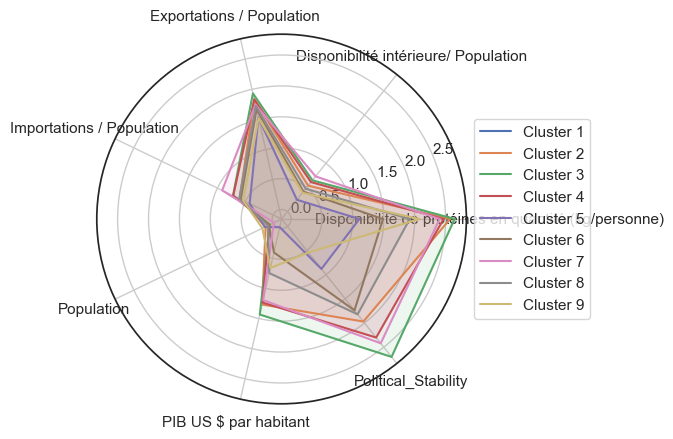

In [261]:
radar_plot(cluster_dd_dfs[0], cluster_dd_dfs[1], cluster_dd_dfs[2], cluster_dd_dfs[3], cluster_dd_dfs[4], cluster_dd_dfs[5], cluster_dd_dfs[6], cluster_dd_dfs[7], cluster_dd_dfs[8])

### Création de la comparaison de le moyenne des valeurs par cluster par rapprot au global

In [262]:
# Calculer la moyenne de chaque variable pour chaque cluster
data_reconstructed_mean = data_reconstructed_num.groupby('cluster_kmeans').mean()
data_reconstructed_mean.drop(['cluster_dd'], axis=1, inplace=True)
data_reconstructed_mean

Disponibilité de protéines en quantité (kg/personne)  \
cluster_kmeans                                                         
0                                                        2.319395      
1                                                        1.533437      
2                                                        2.487931      
3                                                        2.450239      
4                                                        2.060461      
5                                                        2.646021      
6                                                        1.911256      
7                                                        1.131316      
8                                                        2.572691      

                Disponibilité intérieure/ Population  \
cluster_kmeans                                         
0                                           0.466507   
1                                           0.432789   
2                                           0.629982   
3                                           0.749920   
4                                           0.381789   
5                                           0.632846   
6                                           0.467672   
7                                           0.252066   
8                                           0.534323   

                Exportations / Population  Importations / Population  \
cluster_kmeans                                                         
0                                1.709213                   0.564600   
1                                1.670674                   0.601551   
2                                1.834983                   0.739279   
3                                1.743388                   0.937930   
4                                1.497846                   0.534112   
5                                1.931596                   0.699487   
6                                1.719858                   0.600586   
7                                1.537496                   0.426539   
8                                1.833283                   0.598424   

                Population  PIB US $ par habitant  Political_Stability  
cluster_kmeans                                                          
0                 0.157789               0.983771             1.400789  
1                 0.068695               0.443109             1.780074  
2                 0.057345               1.257978             2.369783  
3                -0.022108               1.231687             2.448449  
4                 0.198860               0.633393             0.432354  
5                 0.069230               1.425344             2.650603  
6                 0.095600               0.733254             1.792673  
7                 0.147257               0.007361             0.914817  
8                 0.136156               1.262616             1.948824

In [263]:
# Calculer la moyenne de chaque variable pour l'ensemble du jeu de données
data_reconstructed_num.drop(['cluster_dd', 'cluster_kmeans'], axis=1, inplace=True)
overall_means = data_reconstructed_num.mean()
overall_means

Disponibilité de protéines en quantité (kg/personne)    2.158282
Disponibilité intérieure/ Population                    0.533368
Exportations / Population                               1.748788
Importations / Population                               0.660816
Population                                              0.083867
PIB US $ par habitant                                   0.942214
Political_Stability                                     1.941024
dtype: float64

In [264]:
# Comparer les moyennes de chaque cluster à la moyenne générale
dif = data_reconstructed_mean - overall_means
dif

Disponibilité de protéines en quantité (kg/personne)  \
cluster_kmeans                                                         
0                                                        0.161113      
1                                                       -0.624846      
2                                                        0.329648      
3                                                        0.291957      
4                                                       -0.097821      
5                                                        0.487738      
6                                                       -0.247026      
7                                                       -1.026966      
8                                                        0.414409      

                Disponibilité intérieure/ Population  \
cluster_kmeans                                         
0                                          -0.066861   
1                                          -0.100580   
2                                           0.096614   
3                                           0.216551   
4                                          -0.151579   
5                                           0.099478   
6                                          -0.065696   
7                                          -0.281303   
8                                           0.000955   

                Exportations / Population  Importations / Population  \
cluster_kmeans                                                         
0                               -0.039575                  -0.096215   
1                               -0.078115                  -0.059265   
2                                0.086194                   0.078463   
3                               -0.005400                   0.277114   
4                               -0.250943                  -0.126703   
5                                0.182808                   0.038671   
6                               -0.028930                  -0.060230   
7                               -0.211292                  -0.234277   
8                                0.084495                  -0.062392   

                Population  PIB US $ par habitant  Political_Stability  
cluster_kmeans                                                          
0                 0.073922               0.041558            -0.540235  
1                -0.015172              -0.499104            -0.160950  
2                -0.026522               0.315765             0.428759  
3                -0.105974               0.289473             0.507425  
4                 0.114993              -0.308821            -1.508670  
5                -0.014637               0.483130             0.709579  
6                 0.011733              -0.208959            -0.148351  
7                 0.063391              -0.934853            -1.026207  
8                 0.052289               0.320402             0.007800

In [265]:
dif['cluster_kmeans'] = dif.index
dif.reset_index(drop=True, inplace=True)
dif.head(10)

Disponibilité de protéines en quantité (kg/personne)  \
0                                           0.161113      
1                                          -0.624846      
2                                           0.329648      
3                                           0.291957      
4                                          -0.097821      
5                                           0.487738      
6                                          -0.247026      
7                                          -1.026966      
8                                           0.414409      

   Disponibilité intérieure/ Population  Exportations / Population  \
0                             -0.066861                  -0.039575   
1                             -0.100580                  -0.078115   
2                              0.096614                   0.086194   
3                              0.216551                  -0.005400   
4                             -0.151579                  -0.250943   
5                              0.099478                   0.182808   
6                             -0.065696                  -0.028930   
7                             -0.281303                  -0.211292   
8                              0.000955                   0.084495   

   Importations / Population  Population  PIB US $ par habitant  \
0                  -0.096215    0.073922               0.041558   
1                  -0.059265   -0.015172              -0.499104   
2                   0.078463   -0.026522               0.315765   
3                   0.277114   -0.105974               0.289473   
4                  -0.126703    0.114993              -0.308821   
5                   0.038671   -0.014637               0.483130   
6                  -0.060230    0.011733              -0.208959   
7                  -0.234277    0.063391              -0.934853   
8                  -0.062392    0.052289               0.320402   

   Political_Stability  cluster_kmeans  
0            -0.540235               0  
1            -0.160950               1  
2             0.428759               2  
3             0.507425               3  
4            -1.508670               4  
5             0.709579               5  
6            -0.148351               6  
7            -1.026207               7  
8             0.007800               8

Une valeur négative indique que la moyenne générale est plus importante et inversement.

## Kmeans

### CLuster Kmeans 1

Boxplot et radarplot pour le cluster 0


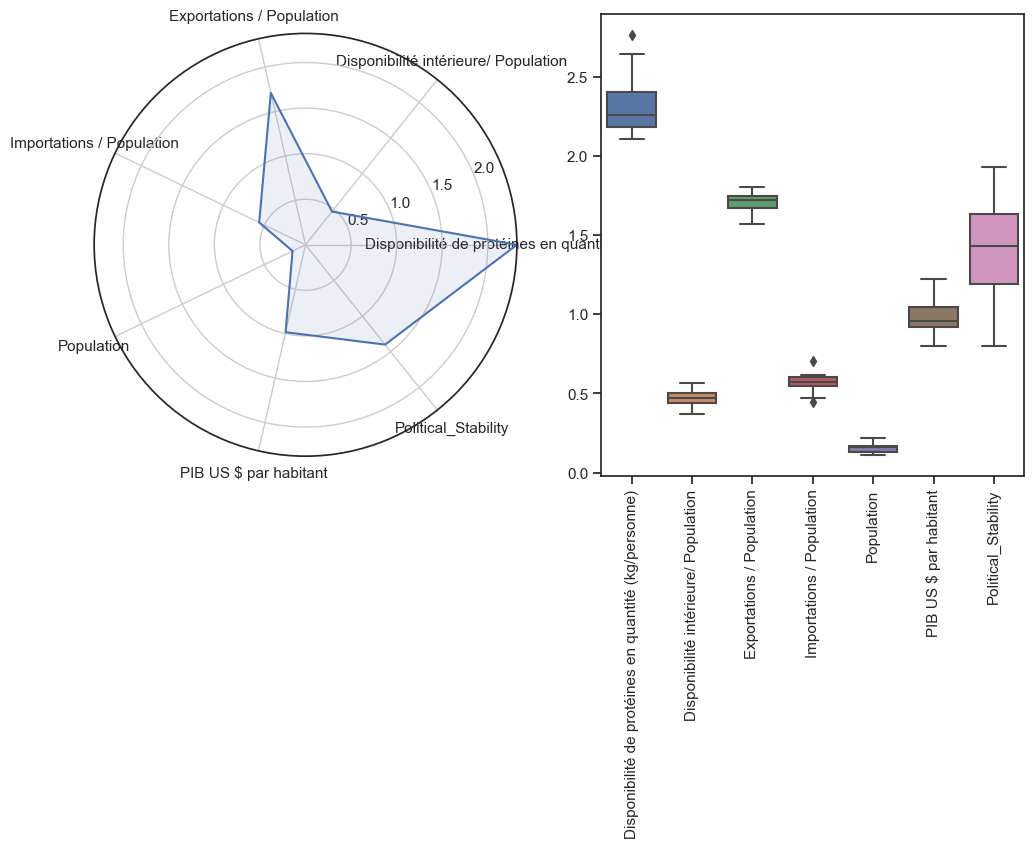

In [266]:
analyze_cluster(cluster_kmeans_dfs[0], 'cluster_kmeans', '0')

In [267]:
cluster_kmeans_dfs[0].describe()

Disponibilité de protéines en quantité (kg/personne)  \
count                                          19.000000      
mean                                            2.319395      
std                                             0.179100      
min                                             2.111272      
25%                                             2.187212      
50%                                             2.257543      
75%                                             2.404722      
max                                             2.767563      

       Disponibilité intérieure/ Population  Exportations / Population  \
count                             19.000000                  19.000000   
mean                               0.466507                   1.709213   
std                                0.050804                   0.058684   
min                                0.371042                   1.571482   
25%                                0.440057                   1.674822   
50%                                0.473969                   1.721511   
75%                                0.500369                   1.747505   
max                                0.565390                   1.804295   

       Importations / Population  Population  PIB US $ par habitant  \
count                  19.000000   19.000000              19.000000   
mean                    0.564600    0.157789               0.983771   
std                     0.061881    0.030896               0.119818   
min                     0.443722    0.112103               0.801263   
25%                     0.546137    0.129134               0.919472   
50%                     0.569420    0.162551               0.956649   
75%                     0.603253    0.169519               1.049064   
max                     0.703078    0.219093               1.224159   

       Political_Stability  
count            19.000000  
mean              1.400789  
std               0.344326  
min               0.800502  
25%               1.189525  
50%               1.429851  
75%               1.635155  
max               1.931910

In [268]:
cluster_kmeans_dfs[0].head()

Pays cluster_kmeans cluster_dd  \
19  Bosnie-Herzégovine              0          9   
33            Colombie              0          9   
42         El Salvador              0          9   
55           Guatemala              0          9   
61            Honduras              0          9   

    Disponibilité de protéines en quantité (kg/personne)  \
19                                           2.257543      
33                                           2.463815      
42                                           2.249453      
55                                           2.270451      
61                                           2.211898      

    Disponibilité intérieure/ Population  Exportations / Population  \
19                              0.499497                   1.765647   
33                              0.482148                   1.721511   
42                              0.487332                   1.769980   
55                              0.501240                   1.703486   
61                              0.456894                   1.729428   

    Importations / Population  Population  PIB US $ par habitant  \
19                   0.599282    0.120291               0.999593   
33                   0.569420    0.167119               1.091399   
42                   0.581730    0.127077               0.991340   
55                   0.619337    0.127111               0.966262   
61                   0.554958    0.146552               0.924695   

    Political_Stability  
19             1.806655  
33             1.386705  
42             1.787992  
55             1.542421  
61             1.541199

In [269]:
cluster_1 = dif[dif['cluster_kmeans'] == 0]
cluster_1

Disponibilité de protéines en quantité (kg/personne)  \
0                                           0.161113      

   Disponibilité intérieure/ Population  Exportations / Population  \
0                             -0.066861                  -0.039575   

   Importations / Population  Population  PIB US $ par habitant  \
0                  -0.096215    0.073922               0.041558   

   Political_Stability  cluster_kmeans  
0            -0.540235               0

- Caractéristiques distinctives : Disponibilité de protéines, disponibilité intérieure, et exportations par habitant positives. Importations par habitant négatives. PIB par habitant et stabilité politique en dessous de la moyenne globale.

- Interprétation potentielle : Ce cluster représente des régions avec une forte disponibilité de protéines, des exportations significatives, mais une stabilité politique et un PIB par habitant relativement bas.

### Cluster Kmeans 2

Boxplot et radarplot pour le cluster 1


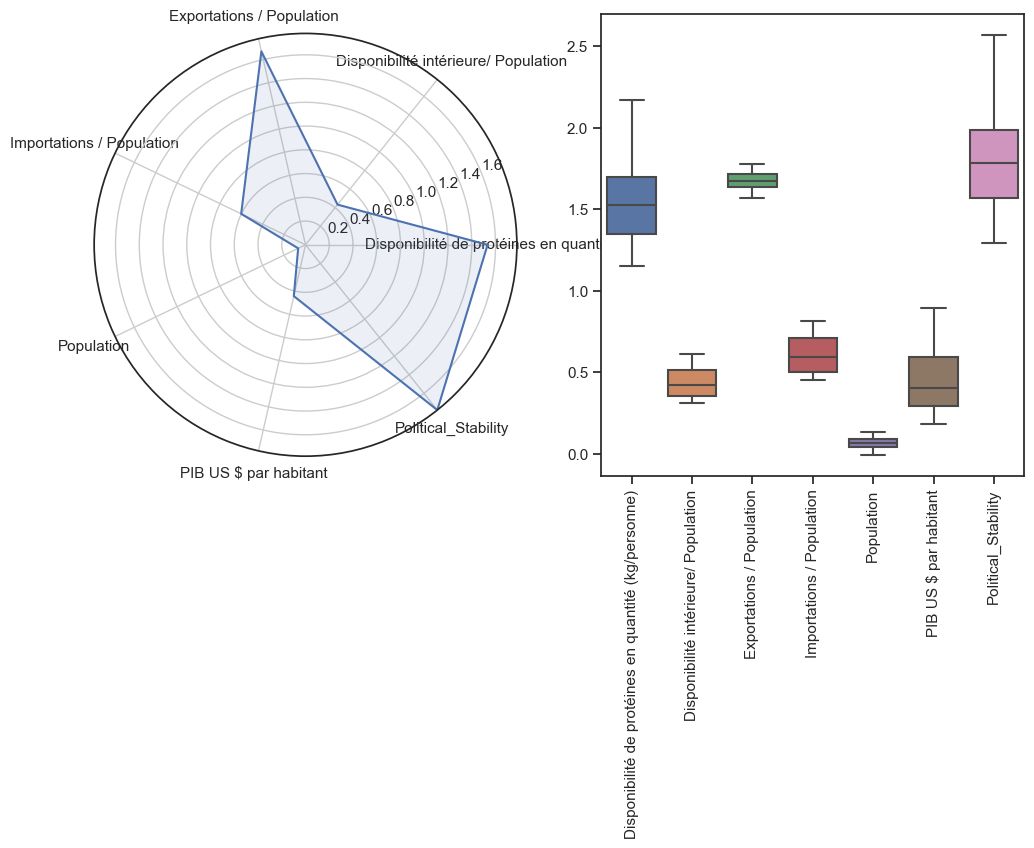

In [270]:
analyze_cluster(cluster_kmeans_dfs[1], 'cluster_kmeans', '1')

In [271]:
cluster_kmeans_dfs[1].describe()

Disponibilité de protéines en quantité (kg/personne)  \
count                                          32.000000      
mean                                            1.533437      
std                                             0.252056      
min                                             1.150044      
25%                                             1.349881      
50%                                             1.522136      
75%                                             1.698258      
max                                             2.168992      

       Disponibilité intérieure/ Population  Exportations / Population  \
count                             32.000000                  32.000000   
mean                               0.432789                   1.670674   
std                                0.091309                   0.049519   
min                                0.309562                   1.567500   
25%                                0.352784                   1.637292   
50%                                0.423748                   1.669321   
75%                                0.512942                   1.716712   
max                                0.612506                   1.779338   

       Importations / Population  Population  PIB US $ par habitant  \
count                  32.000000   32.000000              32.000000   
mean                    0.601551    0.068695               0.443109   
std                     0.110350    0.034365               0.191746   
min                     0.453817   -0.007166               0.180084   
25%                     0.500202    0.043372               0.290639   
50%                     0.594248    0.066523               0.400264   
75%                     0.708435    0.090232               0.594351   
max                     0.813107    0.133540               0.892212   

       Political_Stability  
count            32.000000  
mean              1.780074  
std               0.279658  
min               1.291988  
25%               1.569132  
50%               1.784076  
75%               1.986342  
max               2.568781

In [272]:
cluster_kmeans_dfs[1].head()

Pays cluster_kmeans cluster_dd  \
5         Angola              1          6   
23  Burkina Faso              1          5   
25         Bénin              1          5   
27      Cambodge              1          5   
28      Cameroun              1          5   

    Disponibilité de protéines en quantité (kg/personne)  \
5                                            2.019231      
23                                           1.350611      
25                                           1.910781      
27                                           1.363949      
28                                           1.566118      

    Disponibilité intérieure/ Population  Exportations / Population  \
5                               0.578051                   1.644860   
23                              0.317700                   1.640336   
25                              0.560216                   1.684766   
27                              0.399195                   1.736691   
28                              0.353756                   1.628160   

    Importations / Population  Population  PIB US $ par habitant  \
5                    0.767455    0.042655               0.805702   
23                   0.466870    0.124195               0.249118   
25                   0.740463    0.035022               0.755332   
27                   0.550273    0.060362               0.364017   
28                   0.501056    0.132332               0.395275   

    Political_Stability  
5              1.783916  
23             1.394964  
25             1.977928  
27             2.078038  
28             1.291988

In [273]:
cluster_2 = dif[dif['cluster_kmeans'] == 1]
cluster_2

Disponibilité de protéines en quantité (kg/personne)  \
1                                          -0.624846      

   Disponibilité intérieure/ Population  Exportations / Population  \
1                              -0.10058                  -0.078115   

   Importations / Population  Population  PIB US $ par habitant  \
1                  -0.059265   -0.015172              -0.499104   

   Political_Stability  cluster_kmeans  
1             -0.16095               1

- Caractéristiques distinctives : Disponibilité de protéines, disponibilité intérieure, et importations par habitant négatives. PIB par habitant en dessous de la moyenne globale. Stabilité politique négative.

- Interprétation potentielle : Ce cluster suggère des régions avec une faible disponibilité de protéines, des importations limitées, une stabilité politique négative, et un PIB par habitant relativement bas.

### Cluster Kmeans 3

Boxplot et radarplot pour le cluster 2


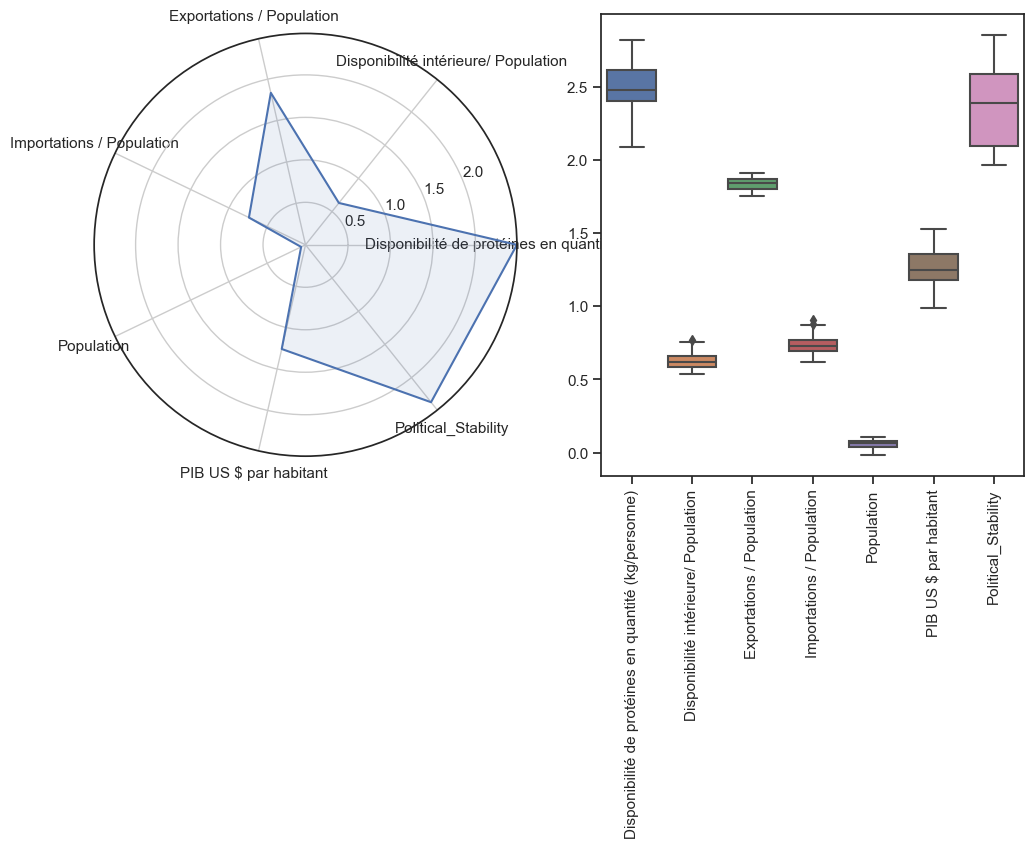

In [274]:
analyze_cluster(cluster_kmeans_dfs[2], 'cluster_kmeans', '2')

In [275]:
cluster_kmeans_dfs[2].describe()

Disponibilité de protéines en quantité (kg/personne)  \
count                                          28.000000      
mean                                            2.487931      
std                                             0.184725      
min                                             2.087727      
25%                                             2.403365      
50%                                             2.480142      
75%                                             2.616565      
max                                             2.815767      

       Disponibilité intérieure/ Population  Exportations / Population  \
count                             28.000000                  28.000000   
mean                               0.629982                   1.834983   
std                                0.060522                   0.045704   
min                                0.536311                   1.752557   
25%                                0.586402                   1.804390   
50%                                0.616067                   1.843292   
75%                                0.659265                   1.872680   
max                                0.770123                   1.909809   

       Importations / Population  Population  PIB US $ par habitant  \
count                  28.000000   28.000000              28.000000   
mean                    0.739279    0.057345               1.257978   
std                     0.072753    0.029654               0.134403   
min                     0.620420   -0.015199               0.984755   
25%                     0.695238    0.035568               1.180675   
50%                     0.726253    0.064420               1.246709   
75%                     0.767889    0.079766               1.359762   
max                     0.907612    0.103495               1.527883   

       Political_Stability  
count            28.000000  
mean              2.369783  
std               0.280524  
min               1.966010  
25%               2.097902  
50%               2.390674  
75%               2.584610  
max               2.854591

In [276]:
cluster_kmeans_dfs[2].head()

Pays cluster_kmeans cluster_dd  \
4         Allemagne              2          3   
7   Arabie saoudite              2          3   
11         Autriche              2          2   
13          Bahamas              2          2   
22         Bulgarie              2          3   

    Disponibilité de protéines en quantité (kg/personne)  \
4                                            2.617696      
7                                            2.740320      
11                                           2.575218      
13                                           2.783864      
22                                           2.407147      

    Disponibilité intérieure/ Population  Exportations / Population  \
4                               0.625586                   1.800572   
7                               0.658274                   1.764871   
11                              0.688810                   1.909809   
13                              0.753157                   1.865715   
22                              0.600335                   1.823614   

    Importations / Population  Population  PIB US $ par habitant  \
4                    0.731605    0.082953               1.314465   
7                    0.776758    0.082001               1.384105   
11                   0.790738    0.022228               1.393672   
13                   0.874715    0.012939               1.527883   
22                   0.708762    0.067011               1.184260   

    Political_Stability  
4              2.101184  
7              1.966010  
11             2.819573  
13             2.690375  
22             2.284070

In [277]:
cluster_3 = dif[dif['cluster_kmeans'] == 2]
cluster_3

Disponibilité de protéines en quantité (kg/personne)  \
2                                           0.329648      

   Disponibilité intérieure/ Population  Exportations / Population  \
2                              0.096614                   0.086194   

   Importations / Population  Population  PIB US $ par habitant  \
2                   0.078463   -0.026522               0.315765   

   Political_Stability  cluster_kmeans  
2             0.428759               2

- Caractéristiques distinctives : Disponibilité de protéines, disponibilité intérieure, exportations et PIB par habitant positives. Stabilité politique au-dessus de la moyenne globale.

- Interprétation potentielle : Ce cluster indique des régions avec une bonne disponibilité de protéines, des exportations significatives, un PIB par habitant élevé, et une stabilité politique positive.

### Cluster Kmeans 4

Boxplot et radarplot pour le cluster 3


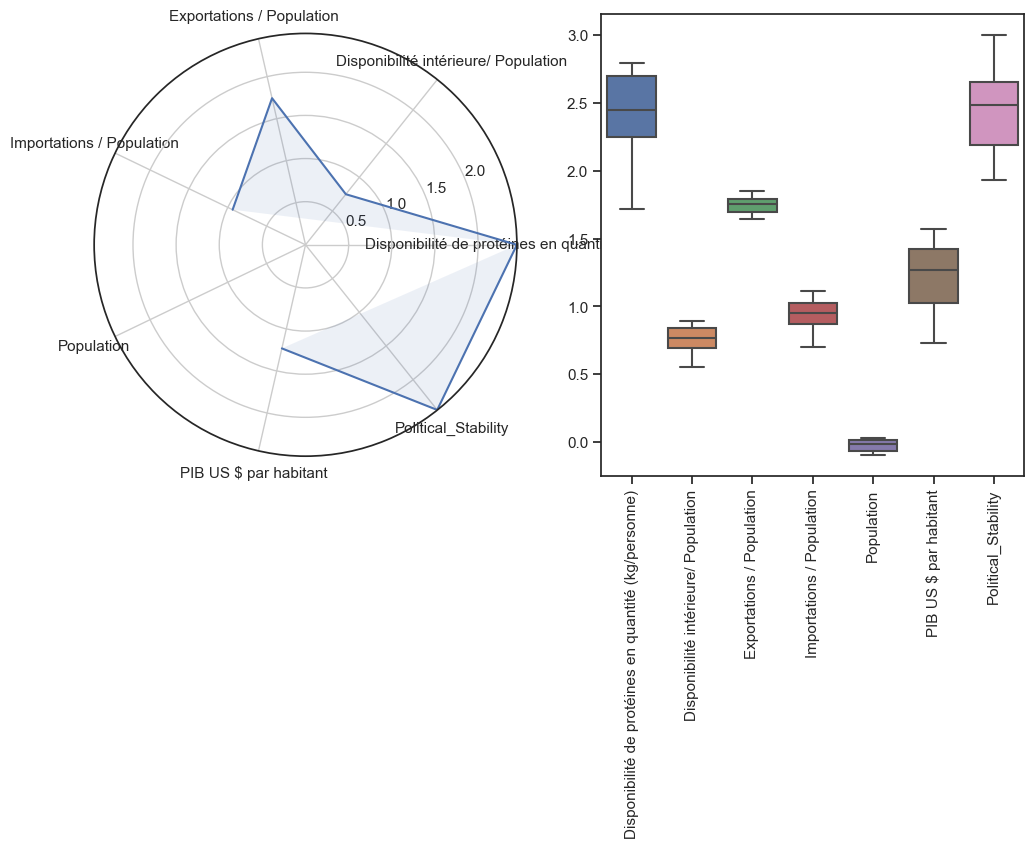

In [278]:
analyze_cluster(cluster_kmeans_dfs[3], 'cluster_kmeans', '3')

In [279]:
cluster_kmeans_dfs[3].describe()

Disponibilité de protéines en quantité (kg/personne)  \
count                                          21.000000      
mean                                            2.450239      
std                                             0.303462      
min                                             1.715410      
25%                                             2.252771      
50%                                             2.448989      
75%                                             2.696755      
max                                             2.794317      

       Disponibilité intérieure/ Population  Exportations / Population  \
count                             21.000000                  21.000000   
mean                               0.749920                   1.743388   
std                                0.101910                   0.057981   
min                                0.551181                   1.644619   
25%                                0.691608                   1.693482   
50%                                0.766507                   1.752742   
75%                                0.838589                   1.789857   
max                                0.889520                   1.853594   

       Importations / Population  Population  PIB US $ par habitant  \
count                  21.000000   21.000000              21.000000   
mean                    0.937930   -0.022108               1.231687   
std                     0.122296    0.038422               0.230175   
min                     0.701152   -0.093967               0.727805   
25%                     0.869936   -0.063051               1.025053   
50%                     0.948476   -0.014047               1.268722   
75%                     1.025568    0.011620               1.421541   
max                     1.113737    0.030942               1.572902   

       Political_Stability  
count            21.000000  
mean              2.448449  
std               0.315105  
min               1.934694  
25%               2.192991  
50%               2.486259  
75%               2.651583  
max               3.003273

In [280]:
cluster_kmeans_dfs[3].head(11)

Pays cluster_kmeans cluster_dd  \
2                Albanie              3          6   
6     Antigua-et-Barbuda              3          6   
20              Botswana              3          6   
26            Cabo Verde              3          6   
31  Chine - RAS de Macao              3          6   
37                  Cuba              3          6   
41             Dominique              3          6   
50                 Gabon              3          6   
83            Luxembourg              3          6   
84     Macédoine du Nord              3          6   
88              Maldives              3          6   

    Disponibilité de protéines en quantité (kg/personne)  \
2                                            2.209980      
6                                            2.696755      
20                                           1.715410      
26                                           2.148247      
31                                           2.787191      
37                                           2.305289      
41                                           2.432196      
50                                           2.448989      
83                                           2.647791      
84                                           2.267143      
88                                           2.252771      

    Disponibilité intérieure/ Population  Exportations / Population  \
2                               0.619541                   1.759058   
6                               0.867240                   1.706860   
20                              0.551181                   1.832439   
26                              0.673910                   1.759861   
31                              0.855446                   1.853594   
37                              0.694761                   1.757679   
41                              0.816338                   1.765727   
50                              0.707343                   1.656636   
83                              0.889520                   1.789948   
84                              0.691608                   1.644619   
88                              0.704892                   1.681071   

    Importations / Population  Population  PIB US $ par habitant  \
2                    0.773268    0.030942               1.025053   
6                    1.090094   -0.063155               1.421530   
20                   0.701152   -0.002146               0.727805   
26                   0.854622   -0.015840               1.013723   
31                   1.020899   -0.056072               1.572902   
37                   0.869936   -0.006820               1.122078   
41                   1.025568   -0.072877               1.268722   
50                   0.904848    0.015670               1.150457   
83                   1.100569   -0.093967               1.458321   
84                   0.903257    0.000845               1.019281   
88                   0.912098   -0.014047               1.041679   

    Political_Stability  
2              2.249046  
6              2.508713  
20             2.726658  
26             2.499021  
31             3.003273  
37             2.432510  
41             2.794784  
50             1.934694  
83             2.976709  
84             1.981083  
88             2.192991

In [281]:
cluster_4 = dif[dif['cluster_kmeans'] == 3]
cluster_4

Disponibilité de protéines en quantité (kg/personne)  \
3                                           0.291957      

   Disponibilité intérieure/ Population  Exportations / Population  \
3                              0.216551                    -0.0054   

   Importations / Population  Population  PIB US $ par habitant  \
3                   0.277114   -0.105974               0.289473   

   Political_Stability  cluster_kmeans  
3             0.507425               3

- Caractéristiques distinctives : Disponibilité de protéines, disponibilité intérieure, importations, et PIB par habitant positives. Stabilité politique au-dessus de la moyenne globale.

- Interprétation potentielle : Des régions prospères avec une disponibilité de protéines, des importations et exportations significatives, un PIB par habitant élevé, et une stabilité politique positive.

### Cluster Kmeans 5

Boxplot et radarplot pour le cluster 4


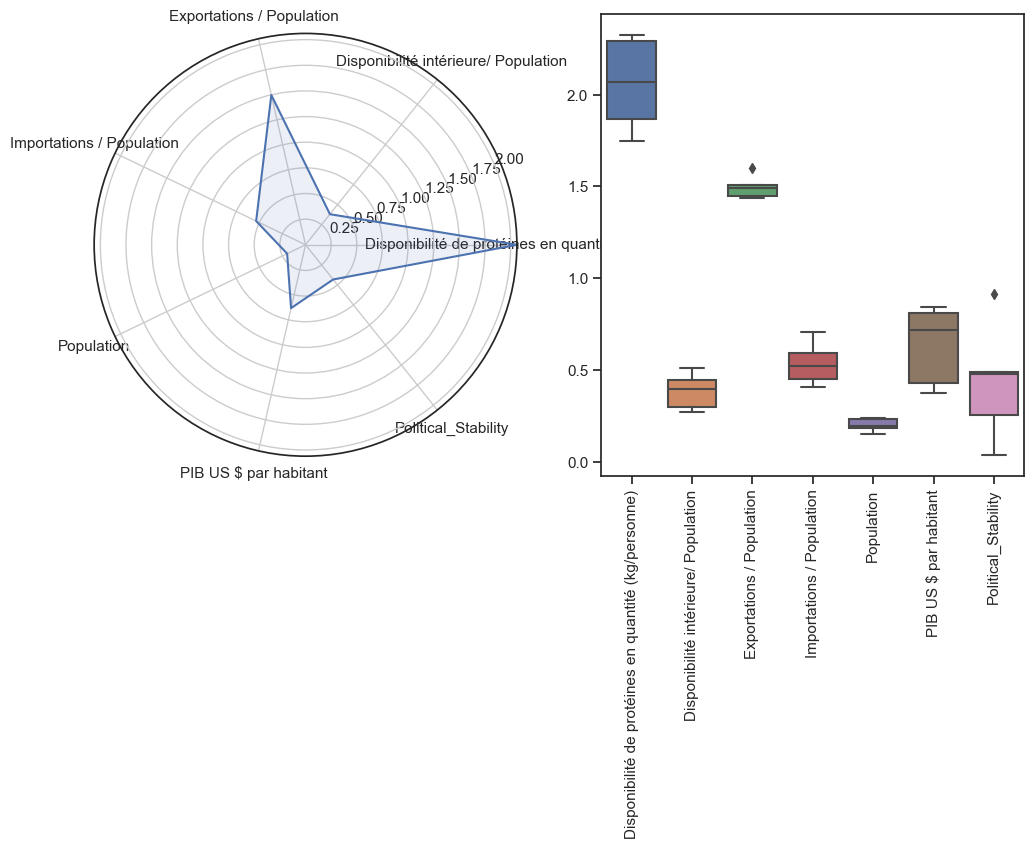

In [282]:
analyze_cluster(cluster_kmeans_dfs[4], 'cluster_kmeans', '4')

In [283]:
cluster_kmeans_dfs[4].describe()

Disponibilité de protéines en quantité (kg/personne)  \
count                                           5.000000      
mean                                            2.060461      
std                                             0.254585      
min                                             1.745933      
25%                                             1.869486      
50%                                             2.069651      
75%                                             2.291203      
max                                             2.326034      

       Disponibilité intérieure/ Population  Exportations / Population  \
count                              5.000000                   5.000000   
mean                               0.381789                   1.497846   
std                                0.100720                   0.065422   
min                                0.267247                   1.438887   
25%                                0.295192                   1.448285   
50%                                0.395553                   1.489589   
75%                                0.442199                   1.509858   
max                                0.508756                   1.602608   

       Importations / Population  Population  PIB US $ par habitant  \
count                   5.000000    5.000000               5.000000   
mean                    0.534112    0.198860               0.633393   
std                     0.118751    0.036240               0.218562   
min                     0.405641    0.150097               0.371358   
25%                     0.448625    0.180397               0.428987   
50%                     0.520783    0.195187               0.717511   
75%                     0.590372    0.232339               0.809192   
max                     0.705142    0.236279               0.839915   

       Political_Stability  
count             5.000000  
mean              0.432354  
std               0.325338  
min               0.036595  
25%               0.252191  
50%               0.475516  
75%               0.485995  
max               0.911473

In [284]:
cluster_kmeans_dfs[4].head(5)

Pays cluster_kmeans cluster_dd  \
65       Iraq              4          8   
80      Liban              4          8   
110  Pakistan              4          8   
158     Yémen              4          8   
161    Égypte              4          8   

     Disponibilité de protéines en quantité (kg/personne)  \
65                                            2.291203      
80                                            2.326034      
110                                           1.745933      
158                                           1.869486      
161                                           2.069651      

     Disponibilité intérieure/ Population  Exportations / Population  \
65                               0.508756                   1.448285   
80                               0.442199                   1.509858   
110                              0.267247                   1.489589   
158                              0.295192                   1.438887   
161                              0.395553                   1.602608   

     Importations / Population  Population  PIB US $ par habitant  \
65                    0.705142    0.150097               0.809192   
80                    0.590372    0.195187               0.839915   
110                   0.405641    0.232339               0.371358   
158                   0.448625    0.236279               0.428987   
161                   0.520783    0.180397               0.717511   

     Political_Stability  
65              0.485995  
80              0.475516  
110             0.252191  
158             0.036595  
161             0.911473

In [285]:
cluster_5 = dif[dif['cluster_kmeans'] == 4]
cluster_5

Disponibilité de protéines en quantité (kg/personne)  \
4                                          -0.097821      

   Disponibilité intérieure/ Population  Exportations / Population  \
4                             -0.151579                  -0.250943   

   Importations / Population  Population  PIB US $ par habitant  \
4                  -0.126703    0.114993              -0.308821   

   Political_Stability  cluster_kmeans  
4             -1.50867               4

- Caractéristiques distinctives : Importations et stabilité politique négatives. Toutes les autres variables proches de la moyenne globale.

- Interprétation potentielle : Ce cluster pourrait représenter des régions avec des importations importantes, une stabilité politique négative, et des autres caractéristiques relativement équilibrées.

### Cluster Kmeans 6

Boxplot et radarplot pour le cluster 5


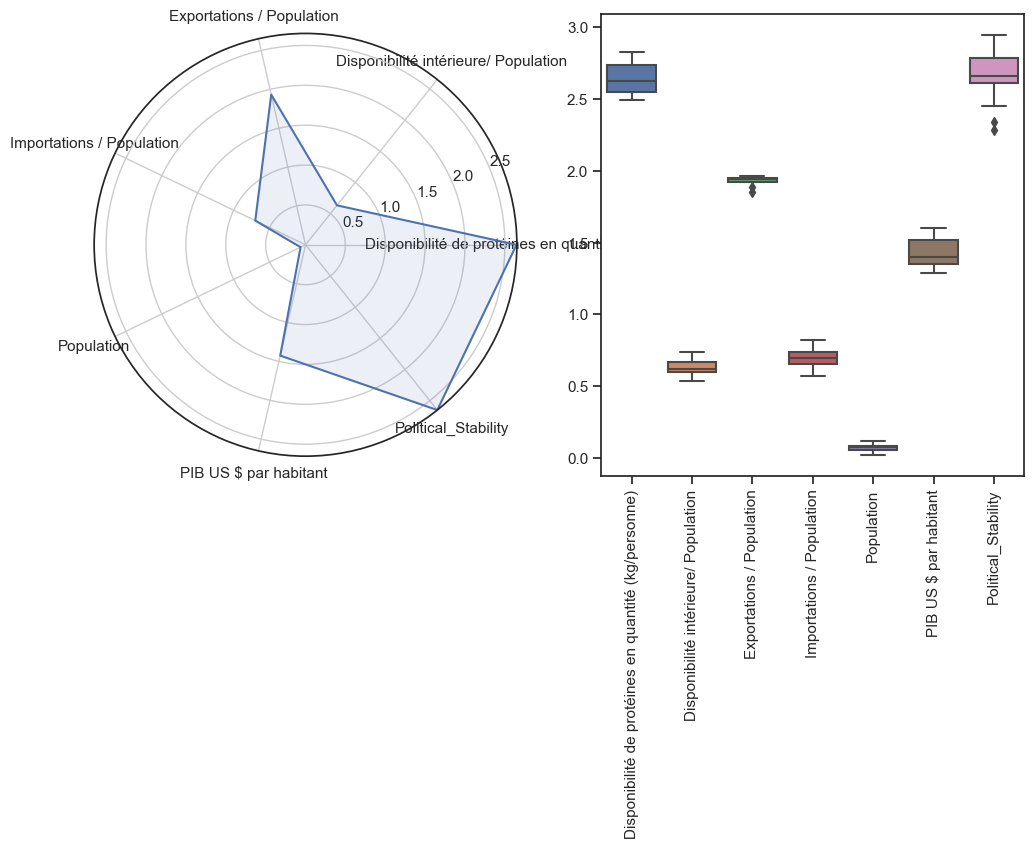

In [286]:
analyze_cluster(cluster_kmeans_dfs[5], 'cluster_kmeans', '5')

In [287]:
cluster_kmeans_dfs[5].describe()

Disponibilité de protéines en quantité (kg/personne)  \
count                                          17.000000      
mean                                            2.646021      
std                                             0.114306      
min                                             2.489798      
25%                                             2.546416      
50%                                             2.623982      
75%                                             2.737476      
max                                             2.825387      

       Disponibilité intérieure/ Population  Exportations / Population  \
count                             17.000000                  17.000000   
mean                               0.632846                   1.931596   
std                                0.055920                   0.027079   
min                                0.534319                   1.852731   
25%                                0.597109                   1.923568   
50%                                0.622754                   1.940400   
75%                                0.666486                   1.948910   
max                                0.736746                   1.961691   

       Importations / Population  Population  PIB US $ par habitant  \
count                  17.000000   17.000000              17.000000   
mean                    0.699487    0.069230               1.425344   
std                     0.069742    0.026234               0.099716   
min                     0.567843    0.021855               1.289342   
25%                     0.657138    0.054057               1.347611   
50%                     0.695516    0.076197               1.399866   
75%                     0.736674    0.085036               1.515074   
max                     0.822991    0.119549               1.601197   

       Political_Stability  
count            17.000000  
mean              2.650603  
std               0.172741  
min               2.280612  
25%               2.614564  
50%               2.656495  
75%               2.782384  
max               2.946783

In [288]:
cluster_kmeans_dfs[5].head(17)

Pays cluster_kmeans cluster_dd  \
10          Australie              5          2   
15            Barbade              5          2   
16           Belgique              5          2   
29             Canada              5          2   
30              Chili              5          1   
39           Danemark              5          2   
47           Finlande              5          2   
48             France              5          3   
62            Hongrie              5          2   
66            Irlande              5          2   
67            Islande              5          2   
82           Lituanie              5          2   
92            Maurice              5          2   
105  Nouvelle-Zélande              5          2   
114           Pologne              5          2   
116          Portugal              5          2   
136          Slovénie              5          2   

     Disponibilité de protéines en quantité (kg/personne)  \
10                                            2.825387      
15                                            2.725492      
16                                            2.489798      
29                                            2.737476      
30                                            2.596202      
39                                            2.793773      
47                                            2.588699      
48                                            2.631438      
62                                            2.506276      
66                                            2.777223      
67                                            2.822919      
82                                            2.546416      
92                                            2.546377      
105                                           2.680078      
114                                           2.535183      
116                                           2.623982      
136                                           2.555632      

     Disponibilité intérieure/ Population  Exportations / Population  \
10                               0.654638                   1.940400   
15                               0.637971                   1.944185   
16                               0.566415                   1.925912   
29                               0.669761                   1.951209   
30                               0.589102                   1.884858   
39                               0.701289                   1.923568   
47                               0.666486                   1.922761   
48                               0.618084                   1.852731   
62                               0.566575                   1.961691   
66                               0.724518                   1.920566   
67                               0.736746                   1.949042   
82                               0.597109                   1.943418   
92                               0.606008                   1.929792   
105                              0.622754                   1.954336   
114                              0.534319                   1.945738   
116                              0.647621                   1.948910   
136                              0.618989                   1.938018   

     Importations / Population  Population  PIB US $ par habitant  \
10                    0.710735    0.079818               1.555788   
15                    0.695516    0.076197               1.486795   
16                    0.622835    0.092607               1.289342   
29                    0.736674    0.055307               1.515074   
30                    0.657138    0.096697               1.340062   
39                    0.783876    0.044559               1.547643   
47                    0.754408    0.038375               1.399866   
48                    0.704082    0.085036               1.354967   
62                    0.610716    0.091412               1.324243   
66          

In [289]:
cluster_6 = dif[dif['cluster_kmeans'] == 5]
cluster_6

Disponibilité de protéines en quantité (kg/personne)  \
5                                           0.487738      

   Disponibilité intérieure/ Population  Exportations / Population  \
5                              0.099478                   0.182808   

   Importations / Population  Population  PIB US $ par habitant  \
5                   0.038671   -0.014637                0.48313   

   Political_Stability  cluster_kmeans  
5             0.709579               5

- Caractéristiques distinctives : Disponibilité de protéines, disponibilité intérieure, exportations, et PIB par habitant positives. Stabilité politique au-dessus de la moyenne globale.

- Interprétation potentielle : Ce cluster suggère des régions avec une forte disponibilité de protéines, des exportations significatives, un PIB par habitant élevé, et une stabilité politique positive.

### Cluster Kmeans 7

Boxplot et radarplot pour le cluster 6


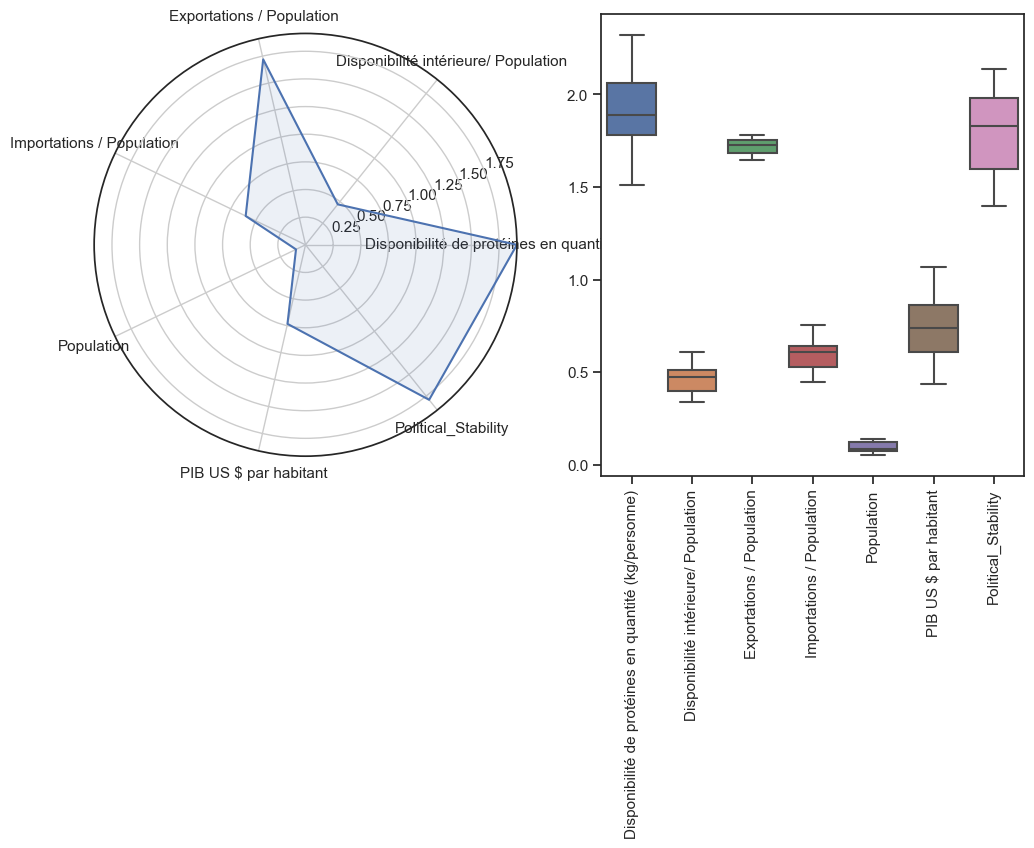

In [290]:
analyze_cluster(cluster_kmeans_dfs[6], 'cluster_kmeans', '6')

In [291]:
cluster_kmeans_dfs[6].describe()

Disponibilité de protéines en quantité (kg/personne)  \
count                                          18.000000      
mean                                            1.911256      
std                                             0.219878      
min                                             1.513698      
25%                                             1.782314      
50%                                             1.889366      
75%                                             2.061278      
max                                             2.321675      

       Disponibilité intérieure/ Population  Exportations / Population  \
count                             18.000000                  18.000000   
mean                               0.467672                   1.719858   
std                                0.074687                   0.041918   
min                                0.340330                   1.646069   
25%                                0.398791                   1.683990   
50%                                0.472770                   1.725755   
75%                                0.510104                   1.753677   
max                                0.608855                   1.779994   

       Importations / Population  Population  PIB US $ par habitant  \
count                  18.000000   18.000000              18.000000   
mean                    0.600586    0.095600               0.733254   
std                     0.086620    0.027672               0.174612   
min                     0.449999    0.055121               0.439040   
25%                     0.528362    0.078130               0.610400   
50%                     0.608304    0.085284               0.739023   
75%                     0.644962    0.122177               0.866144   
max                     0.757325    0.142670               1.069544   

       Political_Stability  
count            18.000000  
mean              1.792673  
std               0.237161  
min               1.398195  
25%               1.595228  
50%               1.827762  
75%               1.983305  
max               2.134579

In [292]:
cluster_kmeans_dfs[6].head(18)

Pays cluster_kmeans cluster_dd  \
3                 Algérie              6          7   
9                 Arménie              6          7   
12            Azerbaïdjan              6          9   
45               Eswatini              6          7   
59                Géorgie              6          7   
63              Indonésie              6          7   
81                Libéria              6          7   
87                 Malawi              6          7   
96             Monténégro              6          7   
112              Paraguay              6          7   
132  Sao Tomé-et-Principe              6          7   
133                Serbie              6          7   
138             Sri Lanka              6          7   
142               Sénégal              6          7   
148                  Togo              6          7   
151          Turkménistan              6          7   
157              Viet Nam              6          7   
160              Zimbabwe              6          7   

     Disponibilité de protéines en quantité (kg/personne)  \
3                                             1.834476      
9                                             2.208589      
12                                            2.151989      
45                                            1.919990      
59                                            2.196401      
63                                            1.780915      
81                                            1.786512      
87                                            1.513698      
96                                            2.321675      
112                                           1.858741      
132                                           1.928879      
133                                           2.078009      
138                                           1.951035      
142                                           1.621985      
148                                           1.725371      
151                                           1.858438      
157                                           2.011086      
160                                           1.654823      

     Disponibilité intérieure/ Population  Exportations / Population  \
3                                0.395235                   1.672060   
9                                0.569631                   1.646069   
12                               0.478963                   1.691324   
45                               0.485668                   1.721092   
59                               0.559517                   1.693630   
63                               0.370319                   1.729469   
81                               0.466577                   1.678888   
87                               0.340330                   1.750891   
96                               0.608855                   1.728447   
112                              0.464912                   1.765024   
132                              0.524828                   1.756260   
133                              0.513470                   1.779994   
138                              0.466557                   1.754130   
142                              0.409460                   1.752318   
148                              0.388203                   1.656952   
151                              0.500003                   1.723062   
157                              0.495942                   1.776293   
160                              0.379633                   1.681545   

     Importations / Population  Population  PIB US $ par habitant  \
3                     0.520978    0.139017               0.615827   
9                     0.737897    0.076349               0.922178   
12                    0.602820    0.126192               0.871838   
45                    0.624535    0.084333               0.748627   
59                    0.710507    0.076857               0.941825   
63                    0.473748  

In [293]:
cluster_7 = dif[dif['cluster_kmeans'] == 6]
cluster_7

Disponibilité de protéines en quantité (kg/personne)  \
6                                          -0.247026      

   Disponibilité intérieure/ Population  Exportations / Population  \
6                             -0.065696                   -0.02893   

   Importations / Population  Population  PIB US $ par habitant  \
6                   -0.06023    0.011733              -0.208959   

   Political_Stability  cluster_kmeans  
6            -0.148351               6

- Caractéristiques distinctives : Importations et stabilité politique négatives. Disponibilité de protéines, disponibilité intérieure, et exportations par habitant positives.

- Interprétation potentielle : Ce cluster pourrait représenter des régions avec des importations importantes, une stabilité politique négative, mais également une bonne disponibilité de protéines et des exportations positives.

### Cluster Kmeans 8

Boxplot et radarplot pour le cluster 7


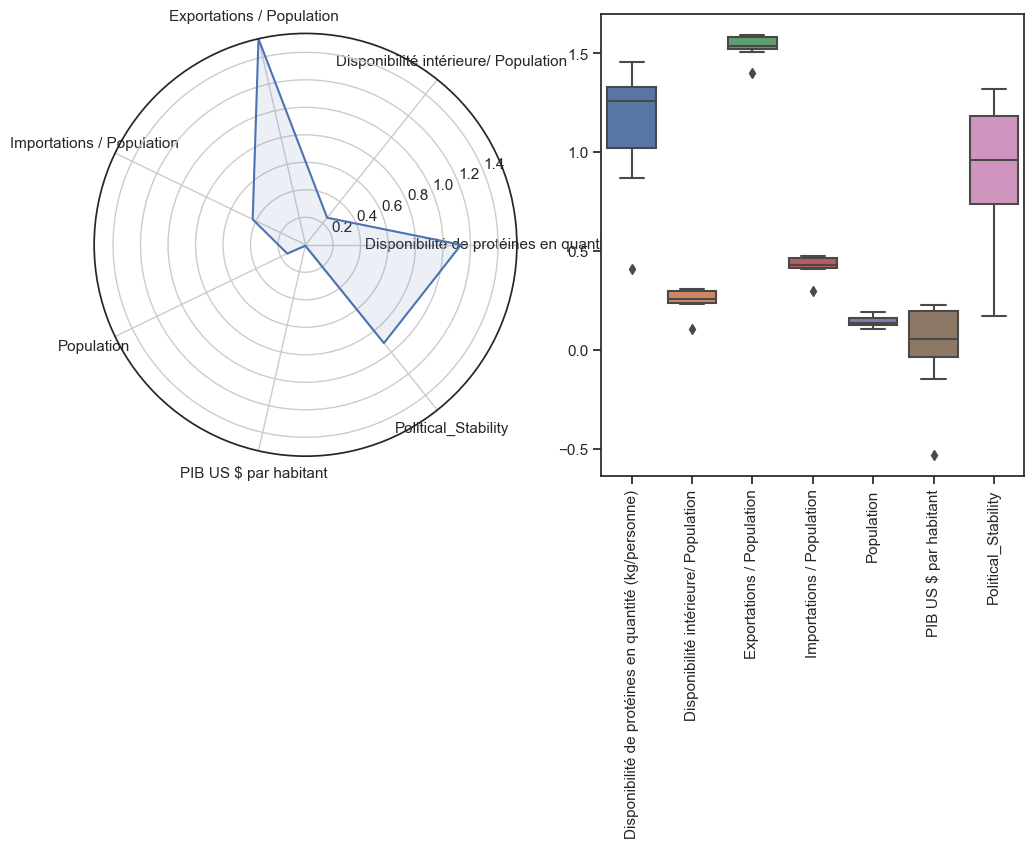

In [294]:
analyze_cluster(cluster_kmeans_dfs[7], 'cluster_kmeans', '7')

In [295]:
cluster_kmeans_dfs[7].describe()

Disponibilité de protéines en quantité (kg/personne)  \
count                                           9.000000      
mean                                            1.131316      
std                                             0.331375      
min                                             0.411568      
25%                                             1.020172      
50%                                             1.257928      
75%                                             1.327931      
max                                             1.457655      

       Disponibilité intérieure/ Population  Exportations / Population  \
count                              9.000000                   9.000000   
mean                               0.252066                   1.537496   
std                                0.059838                   0.060295   
min                                0.110322                   1.402897   
25%                                0.238029                   1.520918   
50%                                0.260986                   1.538936   
75%                                0.297457                   1.585298   
max                                0.307625                   1.593917   

       Importations / Population  Population  PIB US $ par habitant  \
count                   9.000000    9.000000               9.000000   
mean                    0.426539    0.147257               0.007361   
std                     0.053294    0.028523               0.235674   
min                     0.298551    0.108157              -0.527392   
25%                     0.416606    0.130658              -0.033692   
50%                     0.433553    0.140008               0.057671   
75%                     0.468875    0.163785               0.198077   
max                     0.474708    0.192866               0.226775   

       Political_Stability  
count             9.000000  
mean              0.914817  
std               0.362529  
min               0.173446  
25%               0.739847  
50%               0.962106  
75%               1.184445  
max               1.320357

In [296]:
cluster_kmeans_dfs[7].head(18)

Pays cluster_kmeans cluster_dd  \
0    Afghanistan              7          4   
14    Bangladesh              7          5   
74         Kenya              7          4   
89          Mali              7          4   
101        Niger              7          4   
102      Nigéria              7          4   
137       Soudan              7          4   
144        Tchad              7          4   
165     Éthiopie              7          4   

     Disponibilité de protéines en quantité (kg/personne)  \
0                                             1.284617      
14                                            1.327931      
74                                            1.115663      
89                                            1.437934      
101                                           1.020172      
102                                           1.257928      
137                                           1.457655      
144                                           0.868377      
165                                           0.411568      

     Disponibilité intérieure/ Population  Exportations / Population  \
0                                0.238029                   1.402897   
14                               0.307625                   1.593917   
74                               0.297457                   1.592521   
89                               0.273535                   1.538936   
101                              0.245504                   1.585298   
102                              0.260986                   1.506801   
137                              0.300315                   1.520918   
144                              0.234819                   1.570750   
165                              0.110322                   1.525426   

     Importations / Population  Population  PIB US $ par habitant  \
0                     0.433553    0.192866               0.005625   
14                    0.468937    0.132373               0.198077   
74                    0.474708    0.108157               0.057671   
89                    0.427847    0.177606               0.213176   
101                   0.413146    0.130658              -0.033692   
102                   0.436624    0.162830               0.071046   
137                   0.468875    0.163785               0.226775   
144                   0.416606    0.117034              -0.145043   
165                   0.298551    0.140008              -0.527392   

     Political_Stability  
0               0.173446  
14              1.184079  
74              1.320357  
89              0.739847  
101             1.184445  
102             0.712079  
137             0.743913  
144             1.213079  
165             0.962106

In [297]:
cluster_8 = dif[dif['cluster_kmeans'] == 7]
cluster_8

Disponibilité de protéines en quantité (kg/personne)  \
7                                          -1.026966      

   Disponibilité intérieure/ Population  Exportations / Population  \
7                             -0.281303                  -0.211292   

   Importations / Population  Population  PIB US $ par habitant  \
7                  -0.234277    0.063391              -0.934853   

   Political_Stability  cluster_kmeans  
7            -1.026207               7

- Caractéristiques distinctives : Importations et stabilité politique négatives. Toutes les autres variables proches de la moyenne globale.

- Interprétation potentielle : Similaire au Cluster 4, ce cluster pourrait indiquer des régions avec des importations importantes, une stabilité politique négative, et des autres caractéristiques relativement équilibrées.

### Cluster Kmeans 9

Boxplot et radarplot pour le cluster 8


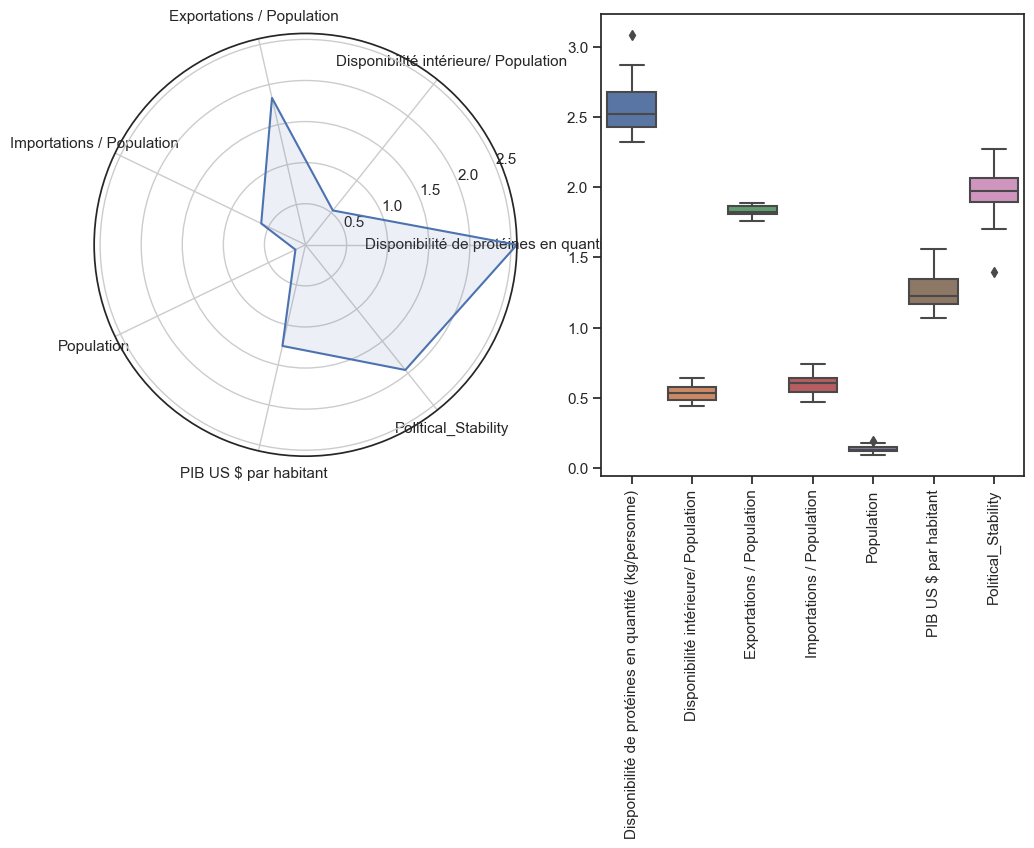

In [298]:
analyze_cluster(cluster_kmeans_dfs[8], 'cluster_kmeans', '8')

In [299]:
cluster_kmeans_dfs[8].describe()

Disponibilité de protéines en quantité (kg/personne)  \
count                                          18.000000      
mean                                            2.572691      
std                                             0.200026      
min                                             2.324179      
25%                                             2.430108      
50%                                             2.522597      
75%                                             2.679219      
max                                             3.084086      

       Disponibilité intérieure/ Population  Exportations / Population  \
count                             18.000000                  18.000000   
mean                               0.534323                   1.833283   
std                                0.059034                   0.035644   
min                                0.440901                   1.756196   
25%                                0.487083                   1.808208   
50%                                0.533858                   1.821243   
75%                                0.573874                   1.866854   
max                                0.642907                   1.886187   

       Importations / Population  Population  PIB US $ par habitant  \
count                  18.000000   18.000000              18.000000   
mean                    0.598424    0.136156               1.262616   
std                     0.070951    0.026184               0.147994   
min                     0.468370    0.093788               1.065930   
25%                     0.543790    0.119942               1.165904   
50%                     0.605659    0.130784               1.225445   
75%                     0.641001    0.146116               1.345615   
max                     0.737872    0.189639               1.561452   

       Political_Stability  
count            18.000000  
mean              1.948824  
std               0.205376  
min               1.394805  
25%               1.894088  
50%               1.968717  
75%               2.065644  
max               2.272631

In [300]:
cluster_kmeans_dfs[8].head(22)

Pays cluster_kmeans  \
1                                       Afrique du Sud              8   
8                                            Argentine              8   
17                                              Belize              8   
18                     Bolivie (État plurinational de)              8   
21                                              Brésil              8   
24                                             Bélarus              8   
43                                             Espagne              8   
49                                Fédération de Russie              8   
58                                              Guyana              8   
64                      Iran (République islamique d')              8   
68                                              Israël              8   
86                                            Malaisie              8   
111                                             Panama              8   
117                                              Pérou              8   
119  Royaume-Uni de Grande-Bretagne et d'Irlande du...              8   
124                             République dominicaine              8   
149                                  Trinité-et-Tobago              8   
164                              États-Unis d'Amérique              8   

    cluster_dd  Disponibilité de protéines en quantité (kg/personne)  \
1            1                                           2.532535      
8            1                                           2.566825      
17           1                                           2.414626      
18           1                                           2.360405      
21           1                                           2.509630      
24           1                                           2.390377      
43           1                                           2.709783      
49           1                                           2.476553      
58           1                                           2.512659      
64           1                                           2.324179      
68           1                                           3.084086      
86           1                                           2.566888      
111          1                                           2.587529      
117          1                                           2.365640      
119          1                                           2.778764      
124          1                                           2.494223      
149          1                                           2.765149      
164          1                                           2.868584      

     Disponibilité intérieure/ Population  Exportations / Population  \
1                                0.560061                   1.807047   
8                                0.534468                   1.876970   
17                               0.484997                   1.863509   
18                               0.445119                   1.807352   
21                               0.440901                   1.851189   
24                               0.479586                   1.868674   
43                               0.591482                   1.796266   
49                               0.533249                   1.814718   
58                               0.530213                   1.827625   
64                               0.493341                   1.812798   
68                               0.589623                   1.756196   
86                               0.526217                   1.867969   
111                              0.566526                   1.886187   
117                              0.456845                   1.806812   
119                              0.642907                   1.810775   
124                              0.543921                   1.814861   
149                              0.622037                   1.856045 

In [301]:
cluster_9 = dif[dif['cluster_kmeans'] == 8]
cluster_9

Disponibilité de protéines en quantité (kg/personne)  \
8                                           0.414409      

   Disponibilité intérieure/ Population  Exportations / Population  \
8                              0.000955                   0.084495   

   Importations / Population  Population  PIB US $ par habitant  \
8                  -0.062392    0.052289               0.320402   

   Political_Stability  cluster_kmeans  
8               0.0078               8

- Caractéristiques distinctives : Disponibilité de protéines, disponibilité intérieure, exportations, et PIB par habitant positives. Importations et stabilité politique proches de la moyenne globale.

- Interprétation potentielle : Ce cluster représente des régions avec une forte disponibilité de protéines, des exportations significatives, un PIB par habitant élevé, et des importations et une stabilité politique relativement équilibrées.

# Sélection des pays

Pour sélectionner notre cluster le plus pertinent on va prendre en compte le PIB par habitant car on a besoin que nos poulets se vendent. On va aussi regadrer la disponibilité alimentaire (avec ou sans protéine) pour avoir une idée de l'état du marché.

9 ?

# Test Dbscan

In [302]:
df_test.head()

F1        F2        F3
0  2.266964 -1.071002  0.457815
1 -0.879198 -0.321601  0.030163
2  0.109542  0.507469  0.065912
3  0.537434 -0.521401 -0.032069
4 -0.821921 -0.024524  0.155151

In [303]:
from sklearn.cluster import DBSCAN

# Assuming that 'df' is your DataFrame and it's already preprocessed
X = df_test.values

# Apply DBSCAN
db = DBSCAN(eps=0.3, min_samples=5).fit(X)

# Get labels
labels = db.labels_

# Add labels to the dataframe
df['Cluster_dbscan'] = labels

import plotly.graph_objects as go

fig = px.scatter_3d(df, x='F1', y='F2', z='F3', color='Cluster_dbscan', color_continuous_scale='Viridis')

fig.update_layout(title='Graphique des clusters en 3D')
fig.show()

In [304]:
df.head()

F1        F2        F3  cluster_kmeans  cluster_dd  Cluster_dbscan
0  2.266964 -1.071002  0.457815               7           4              -1
1 -0.879198 -0.321601  0.030163               8           1               0
2  0.109542  0.507469  0.065912               3           6              -1
3  0.537434 -0.521401 -0.032069               6           7              -1
4 -0.821921 -0.024524  0.155151               2           3               0

In [305]:
df.drop(['cluster_dd','cluster_kmeans'], axis=1, inplace=True)

c:\Users\antoi\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning:

The figure layout has changed to tight



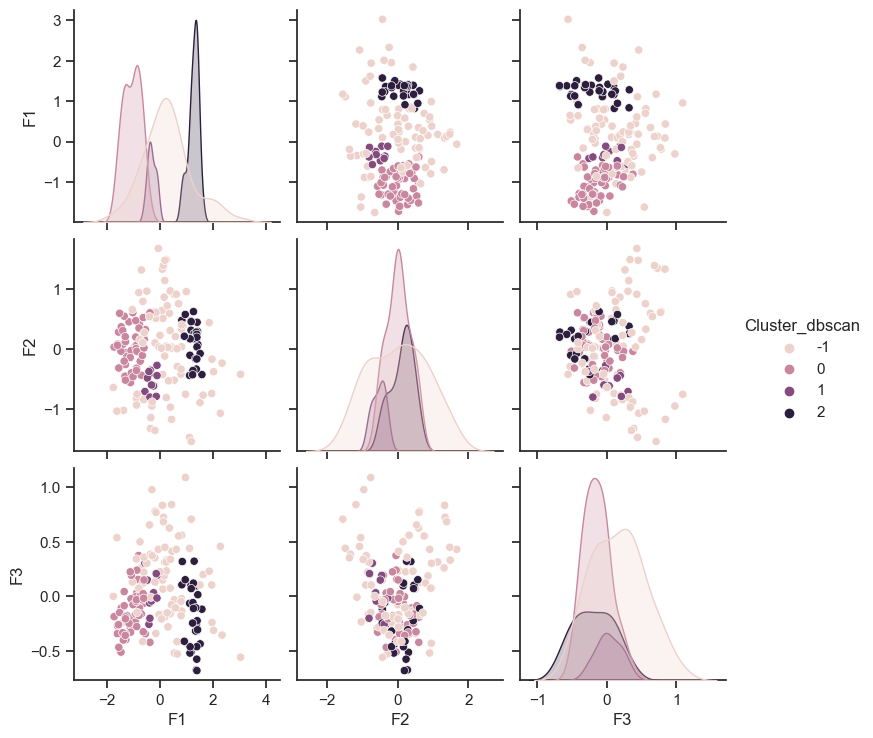

In [306]:
import seaborn as sns
sns.set_theme(style="ticks")
sns.pairplot(df, hue="Cluster_dbscan")

In [307]:
# on va rapprocher nos clusters avec le dataframe initial
data_reconstructed['Cluster_dbscan'] = df['Cluster_dbscan']  

In [308]:
cluster_1 = data[data_reconstructed['Cluster_dbscan'] == 1]
cluster_1.shape

(11, 9)

In [309]:
cluster_1.head(11)

Zone  \
19      Bosnie-Herzégovine   
42             El Salvador   
55               Guatemala   
61                Honduras   
72                Jordanie   
91                   Maroc   
94                 Mexique   
100              Nicaragua   
123  République de Moldova   
146              Thaïlande   
150                Tunisie   

     Disponibilité de protéines en quantité (kg/personne)  \
19                                            0.756489      
42                                            0.771636      
55                                            0.768175      
61                                            0.788510      
72                                            0.844951      
91                                            0.795148      
94                                            0.831687      
100                                           0.786971      
123                                           0.752940      
146                                           0.716277      
150                                           0.772367      

     Disponibilité intérieure/ Population  Exportations / Population  \
19                               0.609502                   0.631002   
42                               0.569932                   0.395329   
55                               0.497724                   0.427701   
61                               0.549720                   0.269745   
72                               0.573811                   0.532572   
91                               0.456626                   0.115679   
94                               0.383030                   0.225021   
100                              0.577253                   0.530050   
123                              0.593927                   0.530050   
146                              0.370990                   0.813405   
150                              0.528095                   0.408214   

     Importations / Population  Production / Population  Population  \
19                    0.664094                 0.733956    0.010150   
42                    0.646659                 0.746263    0.019493   
55                    0.757495                 0.712726    0.051878   
61                    0.579266                 0.743172    0.028849   
72                    0.742202                 0.746894    0.029945   
91                    0.309087                 0.746727    0.109309   
94                    0.759601                 0.762084    0.383731   
100                   0.549091                 0.750256    0.019481   
123                   0.691798                 0.709316    0.012328   
146                   0.202503                 0.756384    0.212770   
150                   0.555266                 0.735777    0.035015   

     PIB US $ par habitant  Political_Stability  
19                0.454903             1.778032  
42                0.405362             1.839817  
55                0.419858             1.572082  
61                0.314728             1.633867  
72                0.408370             1.675057  
91                0.373499             1.764302  
94                0.559696             1.524027  
100               0.292874             1.983982  
123               0.356846             1.798627  
146               0.491208             1.503432  
150               0.385601             1.318078